In [1]:
import logging
import os
import sys
import time
import datetime

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import tensorflow as tf
import seaborn as sns

In [2]:
logging.getLogger('tensorflow').setLevel(logging.ERROR)  # suppress warnings

# Setup Notes

Note: Need to make sure top part of Training Loop (below; used for loading) is the same as was used when creating the network

#### Set the name of the pre-trained network to load.  
The string 'target_network' must be a substring of the target nets 'id_str'

In [15]:
target_network = "v2b__nld_4-dm_128-nh_2-i_0-dr_0__1-opt_adam-lwi_0-bs_64"

# SETUP DATA

### Set input dataset and nb_id

In [3]:
from my_lib.encoding import load_data_encoder

data_encoder = load_data_encoder()

# vars_to_load =  ['CLOCK_DIMS', 'DATA_KEY_ORDER', 'LOSS_TYPES']


# for var in vars_to_load:
#     cmd = f'{var} = data_encoder.field_info["{var}"]'
#     print(cmd)
#     exec(cmd)

### Load training data

In [11]:
inp_tensor = np.load(f"stored_data/inp_tensor.npy")
tar_tensor = np.load(f"stored_data/tar_tensor.npy")
attributes = np.load(f"stored_data/attributes.npy")

inp_tensor.shape, tar_tensor.shape, attributes.shape

((14354, 81, 27), (14354, 80, 9), (14354,))

In [12]:
n_seqs, n_steps, n_feat_inp = inp_tensor.shape
n_feat_tar = tar_tensor.shape[2]

### Split and create tf dataset

In [ ]:
from sklearn.model_selection import train_test_split

x_tr, x_cv, inds_tr, inds_cv, targ_tr, targ_cv = train_test_split(
    inp_tensor, np.arange(n_seqs), tar_tensor, test_size=0.2)

In [ ]:
ds_tr = tf.data.Dataset.from_tensor_slices((x_tr.astype(np.float32), targ_tr.astype(np.float32)))
ds_cv = tf.data.Dataset.from_tensor_slices((x_cv.astype(np.float32), targ_cv.astype(np.float32)))

ds_tr

In [ ]:
from my_lib.transformer_core import make_batches

BUFFER_SIZE = ds_tr.cardinality().numpy()


# Training

## Loss

In [ ]:
def log_normal_pdf(sample, mean, logvar, raxis=1):
    log2pi = tf.math.log(2. * np.pi)
#     log2pi = tf.cast(tf.math.log(2. * np.pi), tf.float64)
    return  -.5 * ((sample - mean) ** 2. * tf.exp(-logvar) + logvar + log2pi)


In [4]:
def log_normal_pdf_gen(sample, mean, logvar, raxis=1):
    log2pi = tf.cast(tf.math.log(2. * np.pi), tf.float64)
    return  -.5 * ((sample - mean) ** 2. * tf.exp(-logvar) + logvar + log2pi)


In [ ]:

from tensorflow.keras.losses import CategoricalCrossentropy, MeanSquaredError, SparseCategoricalCrossentropy


loss_scce_logit = SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

loss_scce_probit = SparseCategoricalCrossentropy(
    from_logits=False, reduction='none')

loss_mse = MeanSquaredError(reduction='none')



def create_padding_mask(seq):
    seq = tf.cast(tf.math.equal(tf.reduce_sum(seq, axis=2), 0), tf.float32)

    # add extra dimensions to add the padding
    # to the attention logits.
    return seq[:, tf.newaxis, tf.newaxis, :]  # (batch_size, 1, 1, seq_len)

def create_look_ahead_mask(size):
    mask = 1 - tf.linalg.band_part(tf.ones((size, size)), -1, 0)
    return mask  # (seq_len, seq_len)



def loss_function(real, pred):
    loss_parts = []
    loss_parts_weighted = []

    for k, k_pred in pred.items():
        
#         print(k, k_pred.shape)

        st = FIELD_STARTS_TAR[k]
        end = st + FIELD_DIMS_TAR[k]
        loss_type = LOSS_TYPES[k]
        

        if loss_type == "scce":
#             print("Sahpes:", real[:, :, st:end].shape, k_pred.shape)
            loss_ = loss_scce_logit(real[:, :, st:end], k_pred)
        elif loss_type == "clock":
            loss_ = loss_scce_probit(real[:, :, st:end], clock_to_onehot(k, k_pred))
        elif loss_type == "mse":
            loss_ = loss_mse(real[:, :, st:end], k_pred)
        elif loss_type == "pdf":
#             print("Sahpes:", real[:, :, st:end].shape, k_pred.shape)
#             print("Sahpes:", k_pred[:,:,0:1].shape,)
#             print(k_pred[:,:,1:2].shape)
#             print( -log_normal_pdf(real[:, :, st:end], k_pred[:,:,0:1], k_pred[:,:,1:2]).shape)
            
            loss_ = -log_normal_pdf(real[:, :, st:end], k_pred[:,:,0:1], k_pred[:,:,1:2])[:,:,0]
#             print("Sahpes:", real[:, :, st:end].shape, k_pred.shape)
#             print("todo - implement pdf loss!")
        else:
            raise Exception(f"Invalid loss type! Got loss type = {loss_type} with key = {k}. Check field_config.py for loss types")
            
#         print(k, loss_.shape)

        mask = tf.math.logical_not(tf.math.equal(tf.reduce_sum(real, axis=2), 0))
        mask = tf.cast(mask, dtype=loss_.dtype)
        loss_ *= mask
        loss_ = tf.reduce_sum(loss_)/tf.reduce_sum(mask) 

        loss_parts.append(loss_)
        loss_parts_weighted.append(loss_ * LOSS_WEIGHTS[k])

    return tf.reduce_sum(loss_parts_weighted), loss_parts




## Set Banksformer configs

In [5]:
ACTIVATIONS = {
    "td_sc": "relu",
    "log_amount_sc": "relu"
}

In [6]:
# vars_to_load =  ['DATA_KEY_ORDER', 'CLOCK_DIMS', 'INP_ENCODINGS', 'TAR_ENCODINGS']
vars_to_load = ['FIELD_DIMS_IN', 'FIELD_STARTS_IN', 'FIELD_DIMS_TAR', 'FIELD_STARTS_TAR', 'FIELD_DIMS_NET', 'FIELD_STARTS_NET', 'DATA_KEY_ORDER']

for var in vars_to_load:
    cmd = f'{var} = data_encoder.field_info["{var}"]'
    print(cmd)
    exec(cmd)

FIELD_DIMS_IN = data_encoder.field_info["FIELD_DIMS_IN"]
FIELD_STARTS_IN = data_encoder.field_info["FIELD_STARTS_IN"]
FIELD_DIMS_TAR = data_encoder.field_info["FIELD_DIMS_TAR"]
FIELD_STARTS_TAR = data_encoder.field_info["FIELD_STARTS_TAR"]
FIELD_DIMS_NET = data_encoder.field_info["FIELD_DIMS_NET"]
FIELD_STARTS_NET = data_encoder.field_info["FIELD_STARTS_NET"]
DATA_KEY_ORDER = data_encoder.field_info["DATA_KEY_ORDER"]


In [7]:
config = {}
# FIELD_DIMS_IN, FIELD_STARTS_IN, FIELD_DIMS_TAR, FIELD_STARTS_TAR, FIELD_DIMS_NET, FIELD_STARTS_NET = get_field_info(ds_suffix)

config["ORDER"] = DATA_KEY_ORDER
config["FIELD_STARTS_IN"] = FIELD_STARTS_IN
config["FIELD_DIMS_IN"] = FIELD_DIMS_IN
config["FIELD_STARTS_NET"] = FIELD_STARTS_NET
config["FIELD_DIMS_NET"] = FIELD_DIMS_NET


config["ACTIVATIONS"] = ACTIVATIONS



## Training Loop 

In [17]:
from my_lib.BanksformerGen import Transformer
import pickle 




found = False
restored = False


all_models = []
for_df = []


def to_num(x):
    try: return int(x)
    except: return float(x)

def id_str_to_folder(id_str):
    return id_str.replace(".", "__")
beta = 1


# moredate
LOSS_WEIGHTS_OLD = {
 'td_sc':1.,
 'year': 0.5,
 'month': 0.15,
 'day': 0.25,
 'dow': 0.1,
 'tcode_num': 1.,
 'log_amount_sc': 2.}


LOSS_WEIGHTS_0 = {
 'td_sc':1.,
 'month': 0.015,
 'day': 0.025,
 'dow': 0.01,
 'tcode_num': 1.,
 'log_amount_sc': 2.}



LOSS_WEIGHTS_MID = {
 'td_sc':1.,
 'month': 0.07,
 'day': 0.1,
 'dow': 0.04,
 'tcode_num': 1.,
 'log_amount_sc': 2.}



lws = [(LOSS_WEIGHTS_0, "0"), (LOSS_WEIGHTS_OLD, "moredate")]

# lws = [(LOSS_WEIGHTS_MID, "mid")]

# td_loss_fns = [(loss_mse, "loss_mse")]


EPOCHS = 80
EARLY_STOP = 2

num_layers_enc = None
dropout_rate = 0.1
dr = dropout_rate
opt_name = "adam"
# td_loss_fn = loss_mse


## Tuned these ! 
d_model = 128
num_layers_dec = 4
num_heads = 2
bs = 64
# lws # above


LOSS_WEIGHTS, lwi = lws[0]


### newer fields, copy loss weights from similar fields
LOSS_WEIGHTS["dtme"] = LOSS_WEIGHTS["day"]
LOSS_WEIGHTS["k_symbol_num"] = LOSS_WEIGHTS["tcode_num"]
LOSS_WEIGHTS["operation_num"] = LOSS_WEIGHTS["tcode_num"]
LOSS_WEIGHTS["type_num"] = LOSS_WEIGHTS["tcode_num"]


dff = d_model


# skip_next = True   
for i in range(3):

#     for num_layers_dec in [3]:
#         for d_model in [32, 128]:
#             for num_heads in [2,4]:
            
                # v

                start = time.time()


                print(datetime.datetime.now().strftime("%H:%M"))


                transformer = Transformer(
                    num_layers_enc=num_layers_enc, num_layers_dec=num_layers_dec,
                    d_model=d_model,
                    num_heads=num_heads,
                    dff=dff,
                    maximum_position_encoding=256,
                   net_info = None, 
                    inp_dim = n_feat_inp,
                    final_dim= None,
                    config=config,
                    rate=dr)

                optimizer = tf.keras.optimizers.Adam()
                transformer.optimizer =  optimizer


                # train_batches = make_batches(ds_tr, BUFFER_SIZE, bs)


#                 transformer.loss_function = loss_function

#                 transformer.LOSS_WEIGHTS = LOSS_WEIGHTS

                id_str = f"v2b__nld_{num_layers_dec}-dm_{d_model}-nh_{num_heads}-i_{i}-dr_{dr}-opt_{opt_name}-lwi_{lwi}-bs_{bs}"
                id_str = id_str_to_folder(id_str)
        

                print("Begin running", id_str)
                transformer.id_str = id_str


                all_models.append(transformer)
                transformer.compile()


                transformer.checkpoint_path = f"./checkpoints/{id_str_to_folder(transformer.id_str)}"
                transformer.ckpt = tf.train.Checkpoint(transformer=transformer,
                                           optimizer=optimizer)
                transformer.ckpt_manager = tf.train.CheckpointManager(transformer.ckpt, 
                                                                      transformer.checkpoint_path, max_to_keep=EARLY_STOP)

                
                
                ## If network already exists, load weights instead of training
                if transformer.ckpt_manager.latest_checkpoint:
                    transformer.ckpt.restore(transformer.ckpt_manager.latest_checkpoint)
                    print('Latest checkpoint restored!!')    
                    restored = True
                    # continue


                    
                    
                if id_str in target_network:
                    print("Found and loaded", target_network)
                    found = True
                    break

 
print("\n\n")
if not found:
    print('Failed to find', target_network)

    if restored:
        print("Using", id_str, "instead")
        
    else:
        print("Failed to load any networks")


12:09
Begin running v2b__nld_4-dm_128-nh_2-i_0-dr_0__1-opt_adam-lwi_0-bs_64
Latest checkpoint restored!!
Found and loaded v2b__nld_4-dm_128-nh_2-i_0-dr_0__1-opt_adam-lwi_0-bs_64





# Generate  
Warning: Code below is not nice and should be refactored

In [18]:
MAX_YEARS_SPAN = 15

## Set up

In [19]:
from my_lib.encoding import encode_time_value
#, decode_time_value

clocks = {}
for max_val in [7, 31, 12]:
    cmd = f"clocks[{max_val}] = np.array([encode_time_value(val, {max_val}) for val in range({max_val})])"
    print("Running", cmd)
    exec(cmd)
    
clocks.keys()

Running clocks[7] = np.array([encode_time_value(val, 7) for val in range(7)])
Running clocks[31] = np.array([encode_time_value(val, 31) for val in range(31)])
Running clocks[12] = np.array([encode_time_value(val, 12) for val in range(12)])


dict_keys([7, 31, 12])

In [20]:
# START_DATE = data_encoder.START_DATE 
START_DATE = str(data_encoder.START_DATE).split()[0]

import calendar
get_dtme = lambda d: calendar.monthrange(d.year, d.month)[1] - d.day

if type(START_DATE) == str:
    START_DATE = datetime.datetime.strptime(START_DATE, "%Y-%m-%d").date()
    
    

END_DATE = START_DATE.replace(year = START_DATE.year+ MAX_YEARS_SPAN)

ALL_DATES = [START_DATE + datetime.timedelta(i) for i in range((END_DATE - START_DATE).days)]

# AD = np.array([(d.month % 12, d.day % 31, d.weekday() % 7, i, d.year) for i, d in enumerate(ALL_DATES)])
AD = np.array([(d.month % 12, d.day % 31, d.weekday() % 7, i, d.year, get_dtme(d)) for i, d in enumerate(ALL_DATES)])



In [72]:
from my_lib.transformer_core import create_masks
from my_lib.encoding import bulk_encode_time_value
    
    
# This function is used when generating new samples
# it takes the raw predictions output by the layer 'net_name' which corrisponds to a data field.
# The predictions encode a probablity distribution, and here we sample the appropiate distribution
# and reencodes the samples to the appropriate input format.
def reencode_net_prediction(net_name, predictions):
    
    # print("reencode_net_prediction:", net_name, predictions.shape)
    
    continous_fields = ['td_sc', "log_amount_sc"]
    cat_fields = data_encoder.field_info["CAT_FIELDS"]
    date_fields = ['month', 'day', 'dtme', 'dow']
    
    batch_size = predictions.shape[0]
    

    # Continous values fields (bs, len, 2), first feature is mean, second is logvar for normal distribtion
    #    need to return shape (bs, len, 1) 
    
    if net_name in continous_fields:
        mean, log_var = predictions[:, :, 0:1],  predictions[:, :, 1:2]
        # sd = np.sqrt(np.exp(log_var))
        log_sd = log_var/2.
        return mean +  log_sd*np.random.normal(size=(batch_size, 1, 1)) 


    

    # Dates are represented as categorical distribution, 
    # and need to be reencoded with the clock encoding
    elif net_name in date_fields:
        dim = FIELD_DIMS_NET[net_name]
        choices = np.arange(dim)
        ps = tf.nn.softmax(predictions, axis=2).numpy().reshape(-1, dim)
        
        choosen =  np.array([np.random.choice(choices, p=p) for p in ps])

        x = bulk_encode_time_value(choosen, max_val=dim)
                
        return np.reshape(x, newshape=(batch_size, -1, 2))
        

    
    # Categorical variables are categorical distributions,
    # and need to be reencoded with one hot encoding
    elif net_name in cat_fields:
    # elif "_num" in net_name:
        dim = FIELD_DIMS_NET[net_name]
        choices = np.arange(dim)

        ps = tf.nn.softmax(predictions, axis=2).numpy().reshape(-1, dim)        
        choosen =  np.reshape([np.random.choice(choices, p=p) for p in ps], newshape=(batch_size, -1))

        return tf.one_hot(choosen, depth=dim)
    
    else:
        raise Exception(f"Got invalid net_name: {net_name}")

        
days_per_month = np.array([(datetime.date(1990, month, 1) - datetime.timedelta(1)).day for month in range(1,13)]) # 0 = dec


@np.vectorize
def get_short_name(tcode):
    return short_names[tcode]


@np.vectorize
def get_date_str(mm, dd):
    return f"{mm:02d}/{dd:02d}"


def bulk_decode(seqs, start_dates, return_single_df=False, return_df_list=False):
    
    # *****
#     ages = age_scaler.inverse_transform(seqs[:, 0, :])
    ages = seqs[:, 0, :] * data_encoder.ATTR_SCALE
    seqs = seqs[:, 1:, :]
    assert np.sum(np.diff(ages)) == 0, f"Bad formating, expected all entries same in each row, got {ages}"

    
    amts = seqs[:, :, FIELD_STARTS_IN["log_amount_sc"]].numpy() * data_encoder.LOG_AMOUNT_SCALE
    amts = 10 ** amts
    amts = np.round(amts - 1.0, 2)


    days_passed = np.round(seqs[:, :, FIELD_STARTS_IN["td_sc"]] *data_encoder.TD_SCALE ).astype(int)
  

#     years = np.round(seqs[:, :, FIELD_STARTS["year"]]/ YEAR_SCALE).astype(int) + START_YEAR

#     months = bulk_nearest_clock_ind(seqs[:, :, FIELD_STARTS["month"]: FIELD_STARTS["month"] +2], 12)
    months = np.argmax(seqs[:, :, FIELD_STARTS_IN["month"]: FIELD_STARTS_IN["month"] + FIELD_DIMS_IN["month"]], axis=-1)
    
    
#     days = bulk_nearest_clock_ind(seqs[:, :, FIELD_STARTS["day"]: FIELD_STARTS["day"] +2], 31)
    days = np.argmax(seqs[:, :, FIELD_STARTS_IN["day"]: FIELD_STARTS_IN["day"] + FIELD_DIMS_IN["day"]], axis=-1)
    days[days==0] = days_per_month[months[days==0]]
    months[months==0] = 12 # needs to be done after days (above)
    date_fields = get_date_str(months, days)
    
    dpc = np.cumsum(days_passed, axis=1) 
    dates = np.array([[start_dates[i] + datetime.timedelta(int(d)) for d in dpc[i]]for i in range(len(start_dates))])
    
    
    code_names = []
    code_vals = []
    for field, start_i in FIELD_STARTS_IN.items():
        if "_num" in field:
            code_names.append(field)
            code_vals.append(np.argmax(seqs[:, :, start_i: start_i + FIELD_DIMS_IN[field]], axis=-1))
        
#     tcode_inds = np.argmax(seqs[:, :, FIELD_STARTS_IN["tcode_num"]: FIELD_STARTS_IN["tcode_num"] + FIELD_DIMS_IN["tcode_num"]], axis=-1)
#     tcodes = get_short_name(tcode_inds)

    ages = np.repeat(ages[:, 0:1], amts.shape[1], axis=1).astype(int)
    

    return_vals = amts, *code_vals, days_passed, ages, dates
    return_lbls = "amount", *code_names, "days_passed", "age", "date"


    if return_df_list:
        return [pd.DataFrame.from_records(zip(*x), columns=return_lbls) for x in zip(*return_vals)]
    
    if return_single_df:
        return pd.DataFrame.from_records([x for x in zip(*[x.reshape(-1) for x in return_vals])], columns=return_lbls)
    
    return return_vals



def nearest_clock_ind(enc, max_val):
    clock = clocks[max_val]
    diffs = clock - enc
    d_sq =  np.sum(diffs**2, axis=1)
    return np.argmin(d_sq)


def nearest_clock_enc(enc, max_val):
    clock = clocks[max_val]
    diffs = clock - enc
    d_sq =  np.sum(diffs**2, axis=1)
    return clock[np.argmin(d_sq)]


def bulk_nearest_clock_ind(encs, max_val):
    batch_size = encs.shape[0]
    inds =  np.array([nearest_clock_ind(enc, max_val) 
                      for enc in tf.reshape(encs, shape=(-1, 2))])
    return inds.reshape((batch_size, -1))


def bulk_nearest_clock_enc(encs, max_val):
    print("Encs shape", encs.shape)

    batch_size = encs.shape[0]
    new_encs =  np.array([nearest_clock_enc(enc, max_val) 
                      for enc in tf.reshape(encs, shape=(-1, encs.shape[-1]))])
    
    print("new_Encs shape", new_encs.shape)
    
    return new_encs.reshape((batch_size, -1, 2))

In [73]:
CAT_FIELDS = data_encoder.field_info["CAT_FIELDS"]

In [74]:
def generate_seqs(length, ages, start_dates, greedy_dates = False, return_single_df=False, return_df_list=False):
    
    if return_single_df and return_df_list:
        raise Exception("At most one of: 'return_single_df' and 'return_df_list' can be true")
    
    date_inds = np.array([(d - START_DATE).days for d in start_dates])
    
    max_length = length

    output = np.repeat(np.array(ages)[:, None, None], repeats=n_feat_inp, axis=2) / data_encoder.ATTR_SCALE
    
    raw_preds = []
    raw_preds.append(output)

    date_info = None
    
    
    for i in range(max_length):


        print("*"*10, f"Generating element {i+1} of {max_length}", "*"*10)
        combined_mask, dec_padding_mask = create_masks(output)

#         return call_to_generate(transformer, output, 
#                                                  True, 
#                                                  combined_mask, 
#                                                  dec_padding_mask, date_inds, date_info, greedy_dates =greedy_dates)
        
        predictions, attn, raw_ps, date_inds, enc_preds, date_info = call_to_generate(transformer, output, 
                                                 True, 
                                                 combined_mask, 
                                                 dec_padding_mask, date_inds, date_info, greedy_dates =greedy_dates)

        
        raw_preds.append(raw_ps)

        enc_preds = tf.reshape(tf.constant(enc_preds), shape=(-1,1, n_feat_inp))

        output = tf.concat([output, enc_preds], axis=1)

        
    return bulk_decode(output, start_dates, return_single_df, return_df_list), output, raw_preds






## Forward pass through transformer
# 
# Returns: preds, attn_w, raw_preds, inds
# the returned preds have multiple timesteps, but we only 
# care about the last (it's the only new one)
def call_to_generate(transformer, tar, training,
           look_ahead_mask, dec_padding_mask, start_inds, prev_date_info=None, greedy_dates = True):
    

    ### Pass through decoder stack ###
    dec_output, attention_weights = transformer.decoder(
        tar, training, look_ahead_mask, dec_padding_mask)


    final_output = transformer.final_layer(dec_output) 

    
    
    ### Predict each field  ###
    preds = {}
    raw_preds = {}
    encoded_preds_d = {}
    encoded_preds = []

    


    for net_name in transformer.ORDER:  
#         print("net =", net_name)
        pred = transformer.__getattribute__(net_name)(final_output)
        raw_preds[net_name] = pred
        
        
        
        
        pred = reencode_net_prediction(net_name, pred) # keeps time step
        
        
        
        if net_name in CAT_FIELDS:

            print("**Generating", net_name.replace('_num', ''))
            
            
            plt_vals = raw_preds[net_name][0,-1].numpy().flatten() # 0 to get first seq in batch
                
            fig, ax = plt.subplots(1,3, figsize=(18,4))
            
            x = data_encoder.__getattribute__(f"num_to_{net_name.replace('_num', '')}".upper())
            lbls = [str(x[i]) for i in range(len(x))]
            
            ax[0].bar(lbls, plt_vals)
            ax[0].set_title("Raw Preds")
            ax[0].tick_params(labelrotation=90)

            
            ax[1].bar(lbls, tf.nn.softmax(plt_vals))
            ax[1].set_title("Probs")
            ax[1].tick_params(labelrotation=90)
            
            plt.xticks(rotation=90)
            

            
            pred_i = np.argmax(pred)
            pred_name = get_code_from_num(data_encoder, net_name.replace("_num", ""), pred_i)
            
            print("Selected", pred_name)
            ax[2].plot([0], [0], marker=f"$ {pred_name} $".replace(" ", "-"), label="month_end", markersize = 150)
            ax[2].set_title("Choosen")
            # ax[2].plot([0], [0], marker=f"$Choosen = {pred_name}$", label="month_end", markersize = 125)
            
            plt.show()  
            
        elif "log" in net_name:
            
            mean_raw = raw_preds[net_name][0,-1,0]
            log_var = raw_preds[net_name][0,-1,1]
            sd = np.exp(log_var/2.)
            print(f"Amount. Unscaled mean = {mean_raw:0.2f},\t logvar = {log_var:0.2f}\t sd = {sd:0.2f}")
                  
                
            val = pred[0,-1,0]
            print(f"Sampled value: {val:0.2f}")
            
            unscaled = 10 ** (val* data_encoder.LOG_AMOUNT_SCALE)
            unscaled = np.round(unscaled - 1.0, 2)
            print(f"Unscaled value: {unscaled:0.2f}")
                  


            
        
        preds[net_name] = pred
        
#         print("Shapes of final_output, pred", final_output.shape, pred.shape)
        encoded_preds_d[net_name] = pred[:,-1,:] 
        encoded_preds.append(pred[:,-1,:])
#         encoded_preds.append(pred[:,-1,:])
        final_output = tf.concat([final_output, pred], axis=2)
            
        
#     inds = np.array([0 for _ in start_inds])
    
    pred_date = None
    
    # print("Encoded preds parts shapes ", [x.shape for x in encoded_preds])
    # print("full shape", tf.expand_dims(tf.concat(encoded_preds, axis=1), axis=1).shape)
    
    
    combined_date_info, inds = raw_dates_to_reencoded(raw_preds, start_inds)
    
    encoded_preds_d.update(combined_date_info)
    
    l = [encoded_preds_d[k] for k in transformer.ORDER]
    encoded_preds =  tf.expand_dims(tf.concat(l, axis=1), axis=1)
    
    
    print("\n\n\n")

    
    return preds, attention_weights, raw_preds, start_inds + inds, encoded_preds, pred_date






In [75]:
def make_bar_plt(vals, ax = None):
    
    if ax is None:
        plt.bar(np.arange(len(vals))+1, vals)
        
    else:
        ax.bar(np.arange(len(vals))+1, vals)

In [76]:
PMF_EPS = 1e-6

# Takes raw predictions (info about predicted day, month, dow, and days passed) and start inds 
# (indicate the current date for each of the seqs) 
# Computes a number of days passed for each based on inputs (either greedily or with sampling)
# returns the new_dates (old_dates + days passed) and their indicies
def raw_dates_to_reencoded(raw, start_inds,  max_days = 100, greedy_decode=False, visual=True):
    

    all_ps = [tf.nn.softmax(raw[k][:,-1]).numpy() for k in ["month", "day", "dow", "dtme"]]

    timesteps = np.zeros(len(start_inds)).astype(int)

    sc = data_encoder.TD_SCALE
    for i, (month_ps, day_ps, dow_ps, dtme_ps, td_pred, si) in enumerate(zip(*all_ps, raw["td_sc"][:,-1].numpy(), start_inds)):
        
        

        ps = month_ps[AD[si:si+max_days,0]]*day_ps[AD[si:si+max_days,1]]*dow_ps[AD[si:si+max_days,2]] *dtme_ps[AD[si:si+max_days,-1]] * \
                np.exp(log_normal_pdf_gen(AD[si:si+max_days,3]-si, mean = td_pred[0]*sc, logvar=td_pred[1]*sc))
#                 pmf(max(PMF_EPS, l_pred)*data_encoder.TD_SCALE, AD[si:si+max_days,3]-si ) 



        if greedy_decode:
            timesteps[i] = np.argmax(ps)
        else:
            timesteps[i] = np.random.choice(max_days, p=ps/sum(ps))
    
###########################################################################

        
        ###########################################################################
        
        if visual and i ==0:  ### Only show first sequence in batch
            
            print("\n\n")
            ######    Individual raw predictions    ######
            
            print("*** Generating next date. Current Date is:", ALL_DATES[si], i)
            print("\n")
            
            fig, ax = plt.subplots(1,5, figsize=(20,4))

            make_bar_plt(day_ps, ax[0])
            make_bar_plt(dtme_ps, ax[1])
            make_bar_plt(dow_ps, ax[2])
            make_bar_plt(month_ps, ax[3])

    
            td_mean = td_pred[0]*sc # linear scale for mean
            
            td_logvar=td_pred[1] + 2*np.log(sc)
            # td_logvar=td_pred[1]*sc

            ax[4].plot([0], [0.08], marker=f"$mean={td_mean:0.2f} $", label="td-m", markersize = 150)
            ax[4].plot([0], [-0.08], marker=f"$sd={np.sqrt(np.exp(td_logvar)):0.2f} $", label="td-sd", markersize = 150)
            ax[4].plot([0], [0.0], marker=f"$logvar={td_logvar:0.2f} $", label="td-lv", markersize = 150)
            ax[4].set_title("Parameters for Time delta distribution (Normal)")
            ax[4].set_ylim([-0.15,0.15])



            for axi, lbl in enumerate(['DoM', 'DTME', 'DoW', 'Month']): 
                ax[axi].set_title(f"{lbl} ps")

                
            plt.tight_layout()
            plt.show()

        ###########################################################################

        
            ######    Individual predictions - # days passed    ######
        
            fig, ax = plt.subplots(1,5, figsize=(20,4))

            ii = 0

            for lbl, vals in zip(['DoM', 'DTME', 'DoW', 'Month', "Time_delta"], 
                                 [day_ps[AD[si:si+max_days,1]], dtme_ps[AD[si:si+max_days,-1]], dow_ps[AD[si:si+max_days,2]],month_ps[AD[si:si+max_days,0]],
                                  np.exp(log_normal_pdf_gen(AD[si:si+max_days,3]-si, mean = td_pred[0]*sc, logvar=td_pred[1] + 2*np.log(sc)))]
                                ):   

                ax[ii].set_xlabel("p(# days passed)")

                to_plot = vals/sum(vals)
                ax[ii].plot(to_plot)
                ax[ii].set_xlim([0, 31])
                ax[ii].set_ylim([0.0, np.max(to_plot)*1.05 ])
                ax[ii].set_title(f"p(# days passed| {lbl})")
                # ax[ii].set_xlabel("p(day until next)")

                # print("Len of", lbl, "is", len(vals))
                ii +=1

            plt.tight_layout()
            plt.show()
        
        
        ###########################################################################

        
            ######    Combined predictions - # days passed    ######
        
            fig, ax = plt.subplots(1,2, figsize=(20,4))

            ii = 0
            
            ax[1].plot(ps/sum(ps))
            ax[1].set_xlabel("p(# days passed)")

            ax[0].set_title(f"p(# days passed) - Each field")
            ax[1].set_title(f"p(# days passed) - Final")
            
            
            ax[1].plot(timesteps[i], np.max(ps/sum(ps)), "*", label="choosen", markersize = 10)
            
            for lbl, vals in zip(['DoM', 'DTME', 'DoW', 'Month', "Time_delta"], 
                                 [day_ps[AD[si:si+max_days,1]], dtme_ps[AD[si:si+max_days,-1]], dow_ps[AD[si:si+max_days,2]],month_ps[AD[si:si+max_days,0]],
                                  np.exp(log_normal_pdf_gen(AD[si:si+max_days,3]-si, mean = td_pred[0]*sc, logvar=td_pred[1]*sc))]
                                ):   
                
                

                
                ax[0].set_xlabel("p(# days passed)")
                ax[0].plot(vals/sum(vals), label=lbl)
                
    
                ii +=1

            ax[0].legend()
            ax[1].legend()
            # plt.legend
            plt.show()


##########################################################################################




        

        # 
        # plt.show()
        
        
    inds = start_inds + timesteps
    
    
    return_ = {}
    return_["td_sc"] = tf.expand_dims(timesteps.astype(np.float32)/ data_encoder.TD_SCALE, axis=1)
    return_["month"] = bulk_encode_time_value(AD[inds, 0], 12)
    return_["day"] = bulk_encode_time_value(AD[inds, 1], 31)
    return_["dow"] = bulk_encode_time_value(AD[inds, 2], 7)
    return_["dtme"] = bulk_encode_time_value(AD[inds, -1], 31)
    
    

    return return_, timesteps
#         tf.expand_dims(
#                 tf.concat([tf.expand_dims(
#                            timesteps.astype(np.float32)/ data_encoder.TD_SCALE, axis=1), 
# #                            AD[inds, 4:5]*YEAR_SCALE,
#                            bulk_encode_time_value(AD[inds, 0], 12),
#                            bulk_encode_time_value(AD[inds, 1], 31),
#                            bulk_encode_time_value(AD[inds, 2], 7)
#               ], axis=1), axis=1), timesteps

In [77]:
def get_code_num(self, field, code):
    field = field.replace("_num", "")
    d = self.__getattribute__(f"{field}_to_num".upper())
    return d[code]



def get_code_from_num(self, field, num):
    field = field.replace("_num", "")
    d = self.__getattribute__(f"num_to_{field}".upper())
    return d[num]

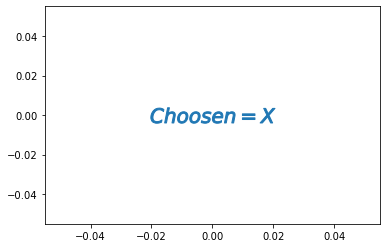

In [78]:
plt.plot([0], [0], marker="$Choosen = X$", label="month_end", markersize = 125)

In [79]:
CAT_FIELDS

['k_symbol_num', 'operation_num', 'type_num']

## Generate example

********** Generating element 1 of 20 **********
**Generating k_symbol
Selected nan


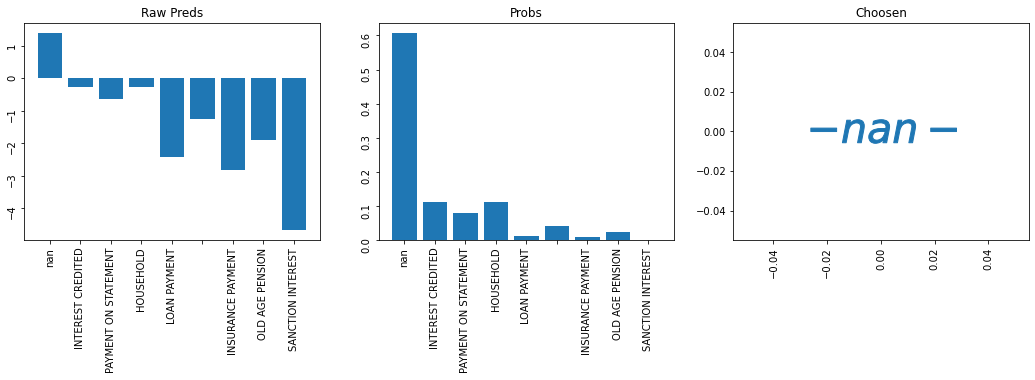

**Generating operation
Selected CASH WITHDRAWAL


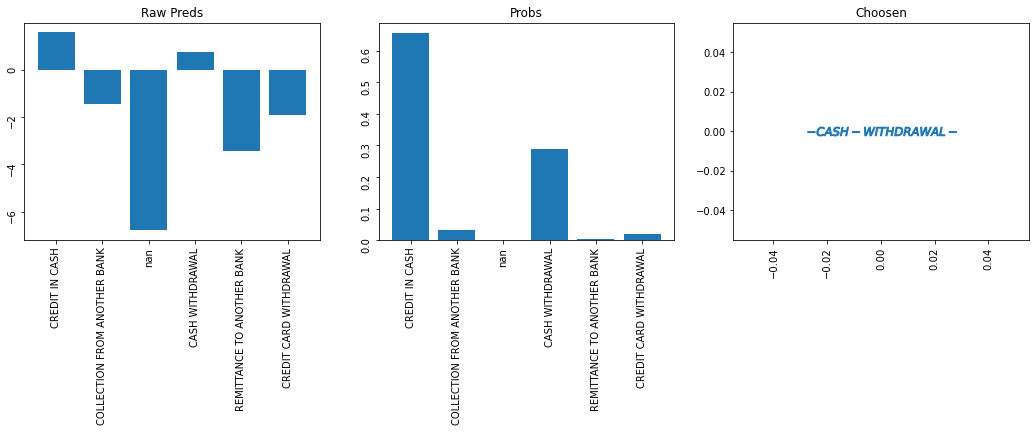

**Generating type
Selected DEBIT


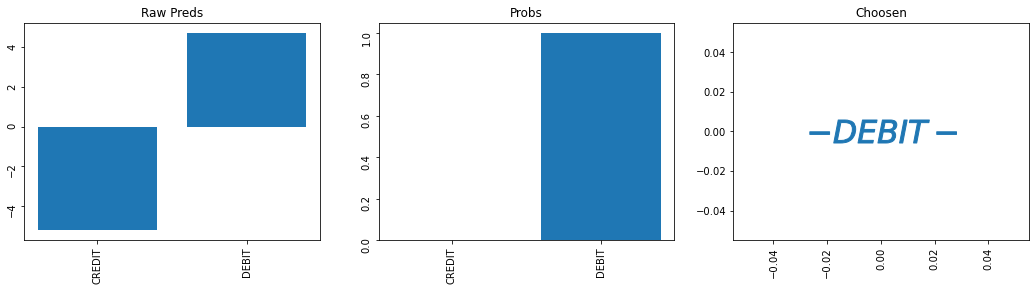

Amount. Unscaled mean = 3.05,	 logvar = 0.00	 sd = 1.00
Sampled value: 3.05
Unscaled value: 1734.90



*** Generating next date. Current Date is: 1993-01-01 0




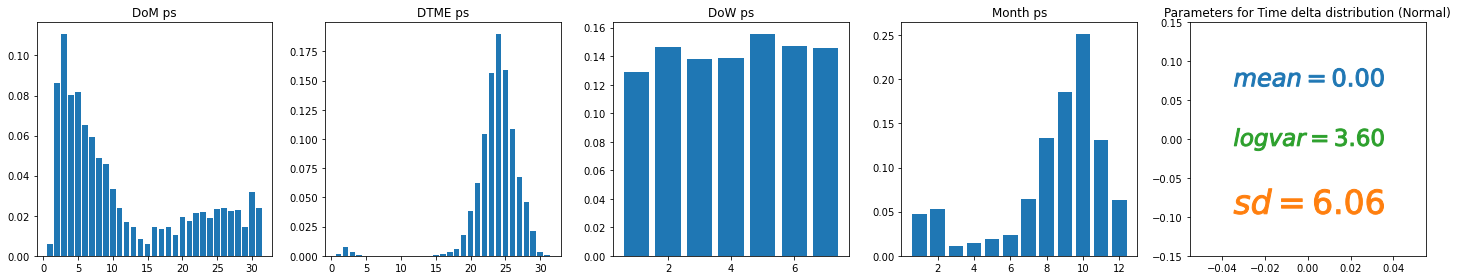

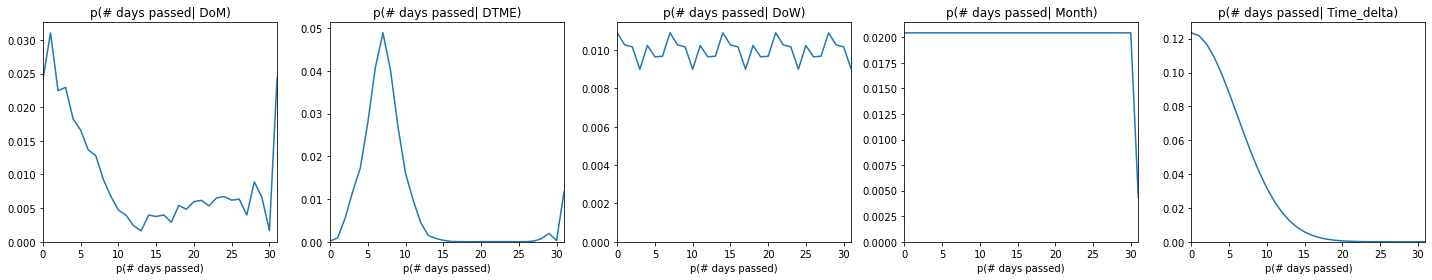

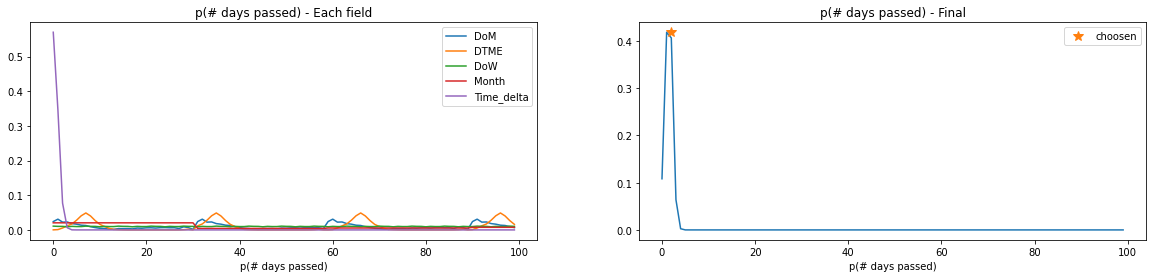





********** Generating element 2 of 20 **********
**Generating k_symbol
Selected HOUSEHOLD


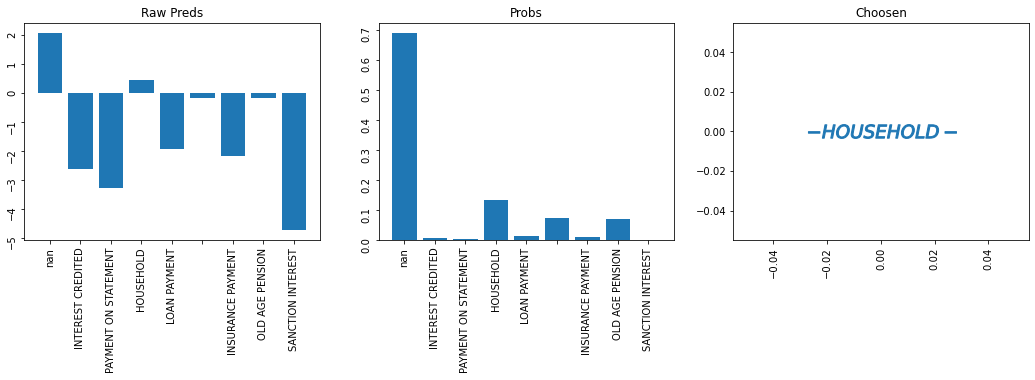

**Generating operation
Selected REMITTANCE TO ANOTHER BANK


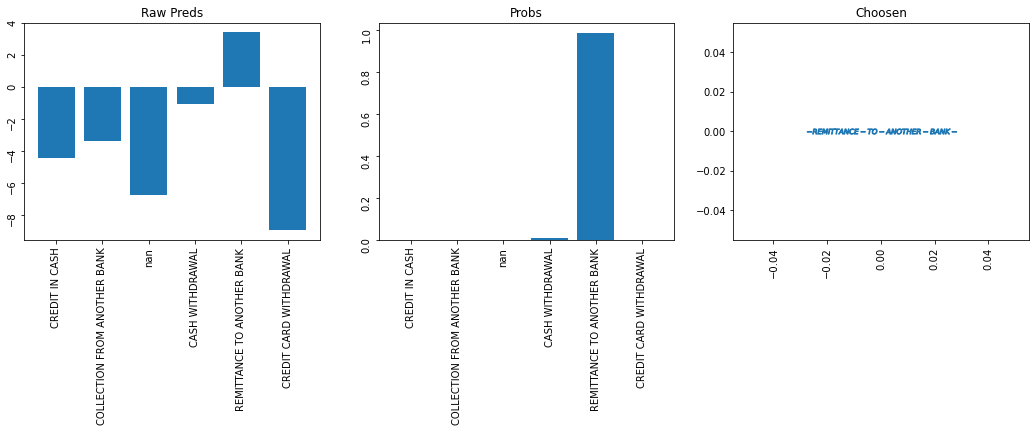

**Generating type
Selected DEBIT


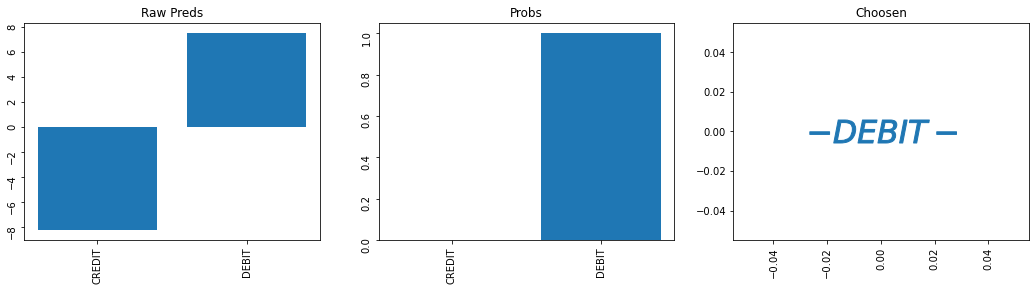

Amount. Unscaled mean = 3.41,	 logvar = 0.00	 sd = 1.00
Sampled value: 3.41
Unscaled value: 4201.58



*** Generating next date. Current Date is: 1993-01-03 0




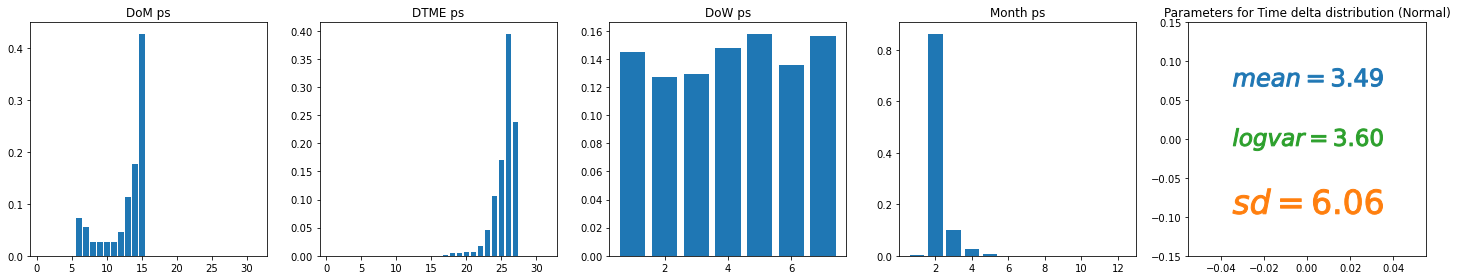

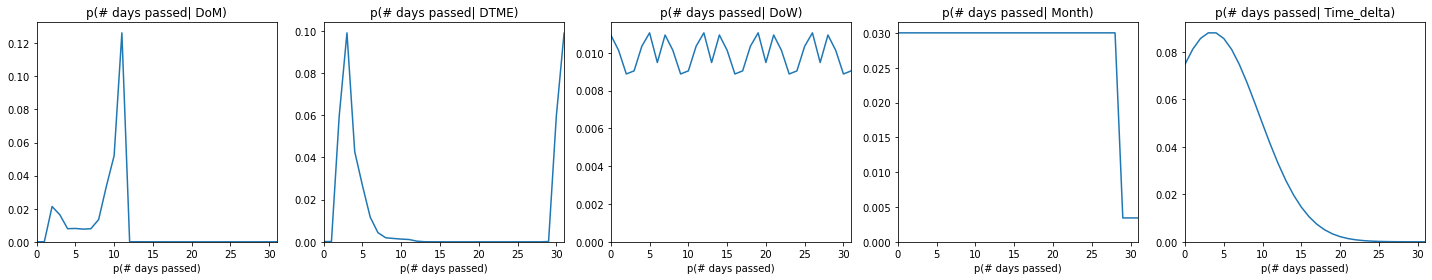

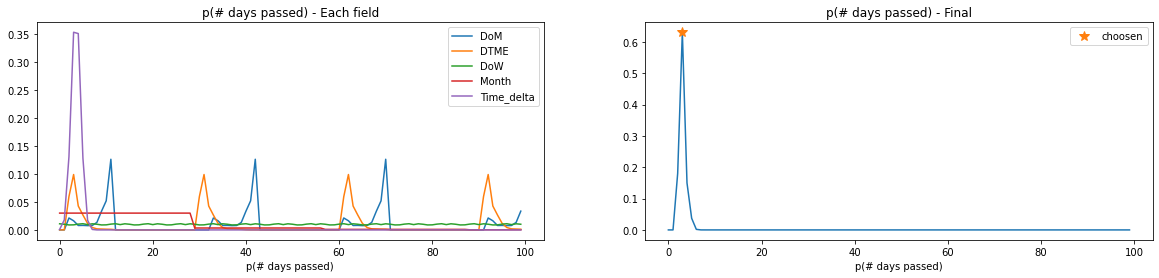





********** Generating element 3 of 20 **********
**Generating k_symbol
Selected INTEREST CREDITED


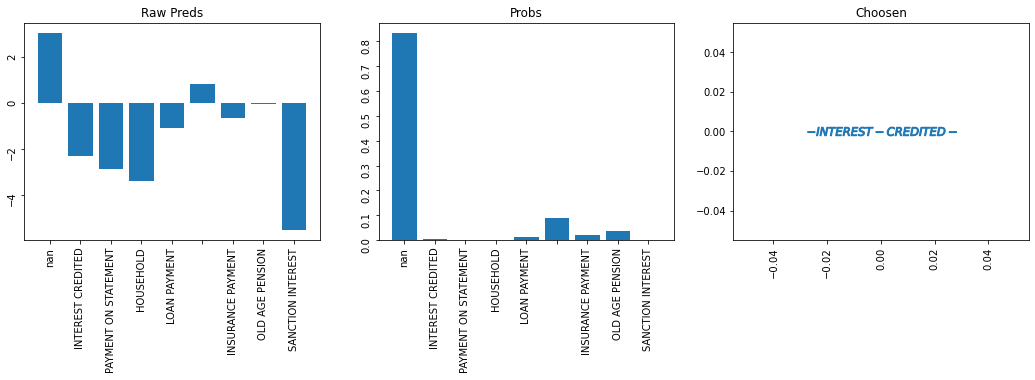

**Generating operation
Selected nan


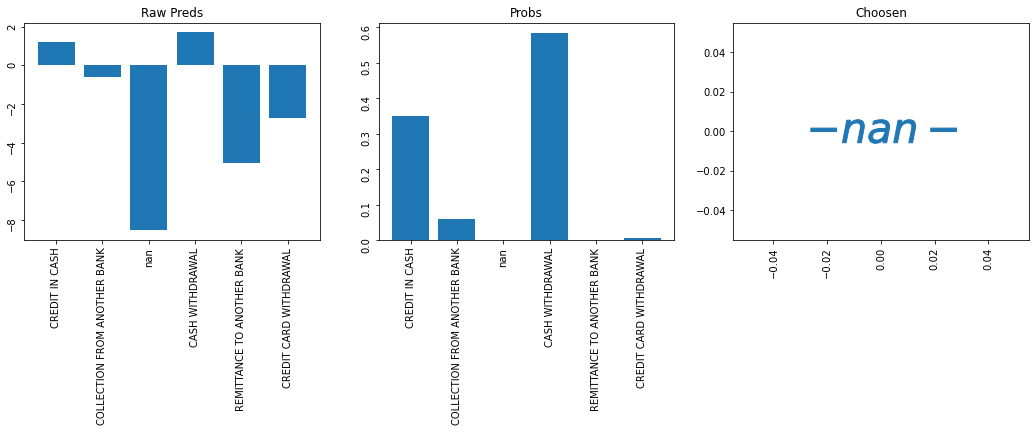

**Generating type
Selected CREDIT


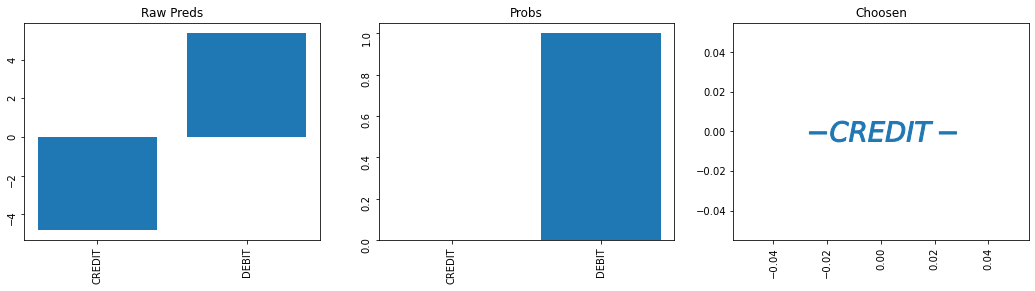

Amount. Unscaled mean = 3.32,	 logvar = 0.00	 sd = 1.00
Sampled value: 3.32
Unscaled value: 3335.01



*** Generating next date. Current Date is: 1993-01-06 0




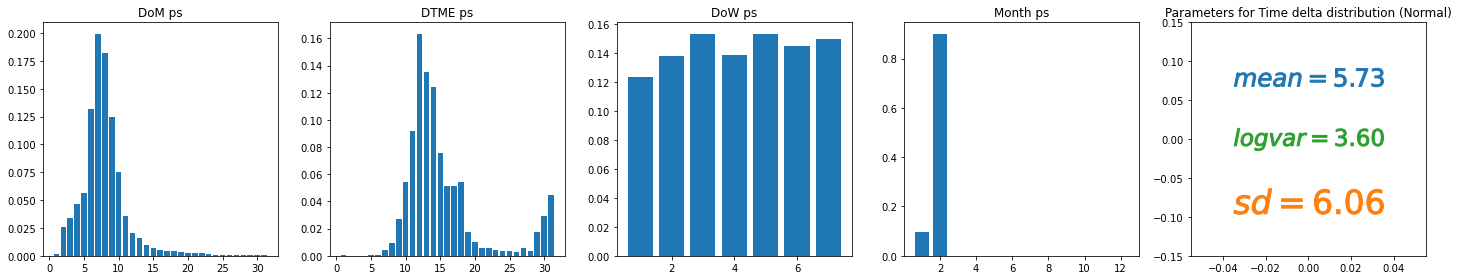

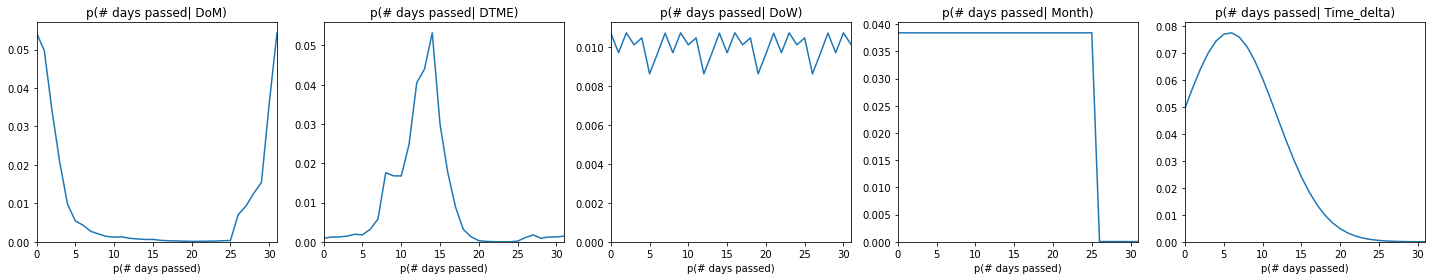

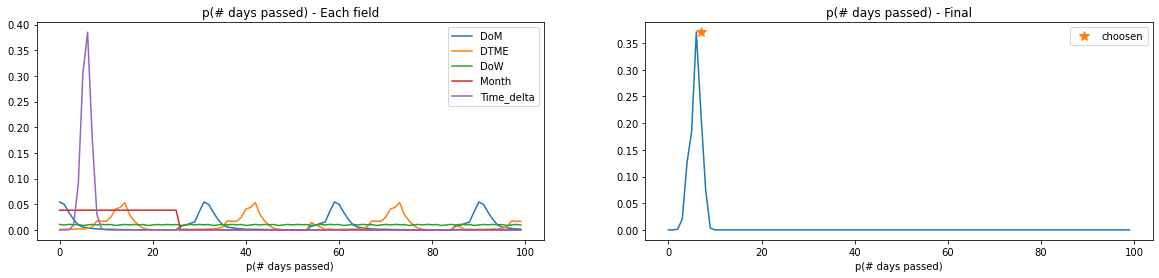





********** Generating element 4 of 20 **********
**Generating k_symbol
Selected nan


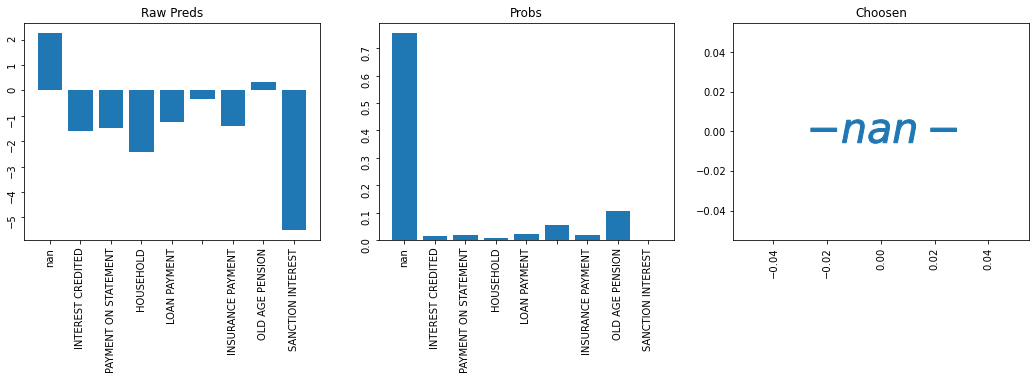

**Generating operation
Selected CASH WITHDRAWAL


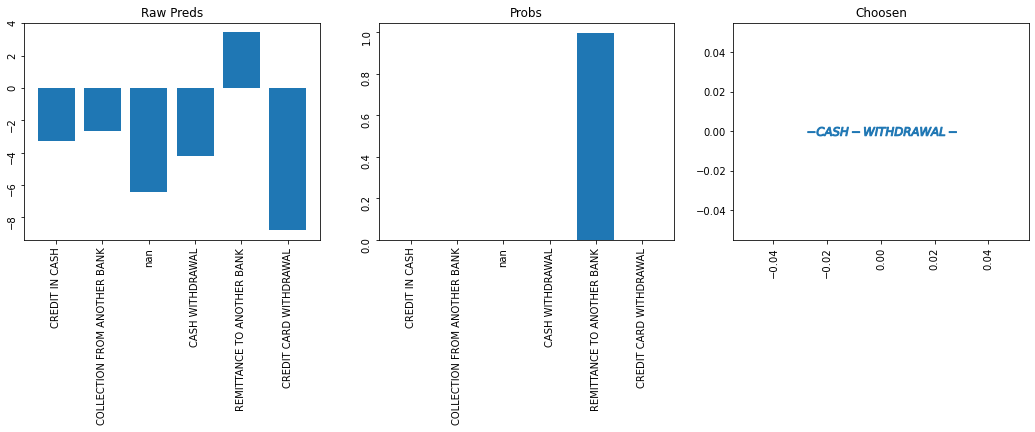

**Generating type
Selected DEBIT


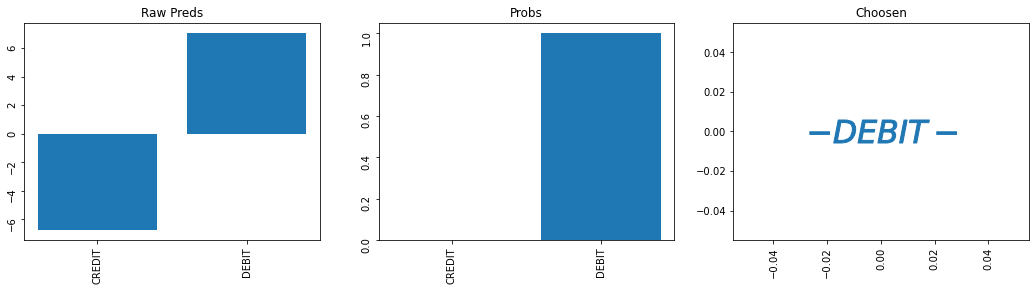

Amount. Unscaled mean = 2.66,	 logvar = 0.00	 sd = 1.00
Sampled value: 2.66
Unscaled value: 677.17



*** Generating next date. Current Date is: 1993-01-13 0




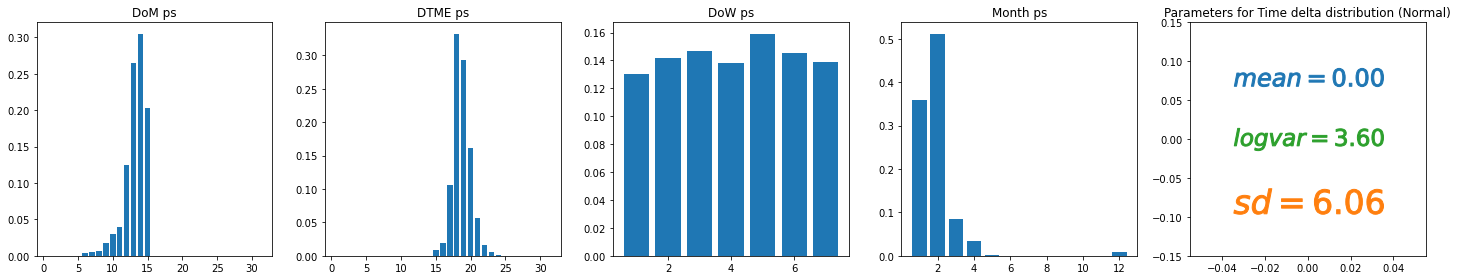

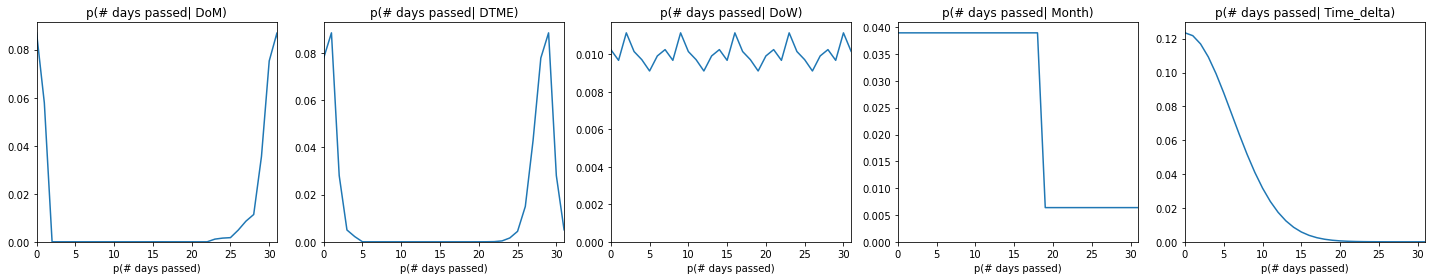

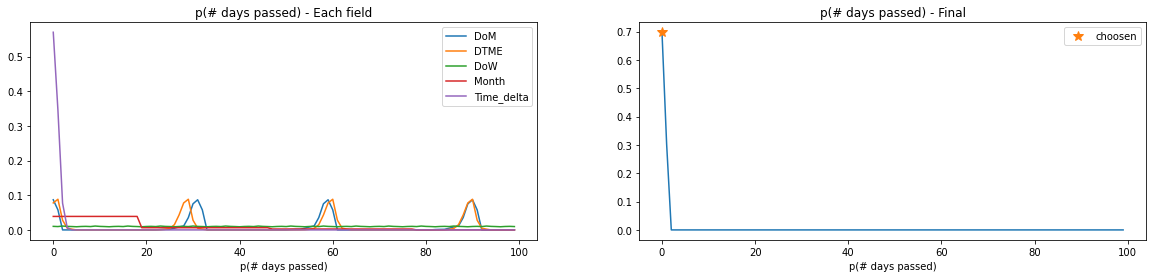





********** Generating element 5 of 20 **********
**Generating k_symbol
Selected INTEREST CREDITED


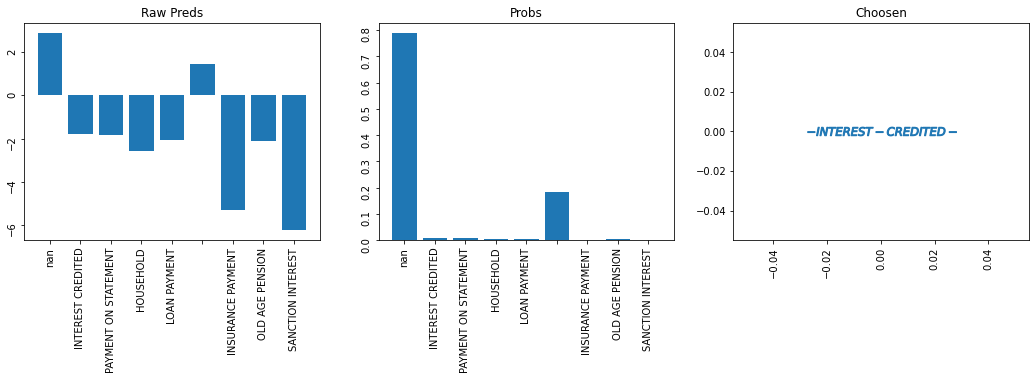

**Generating operation
Selected nan


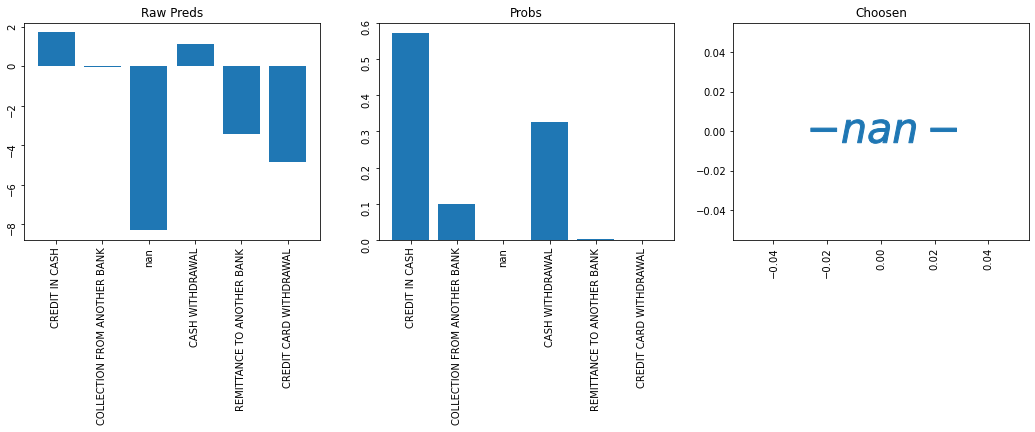

**Generating type
Selected CREDIT


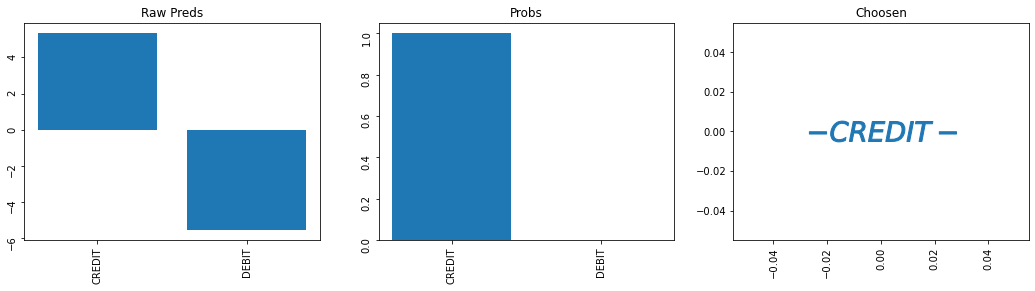

Amount. Unscaled mean = 3.72,	 logvar = 0.00	 sd = 1.00
Sampled value: 3.72
Unscaled value: 8978.07



*** Generating next date. Current Date is: 1993-01-13 0




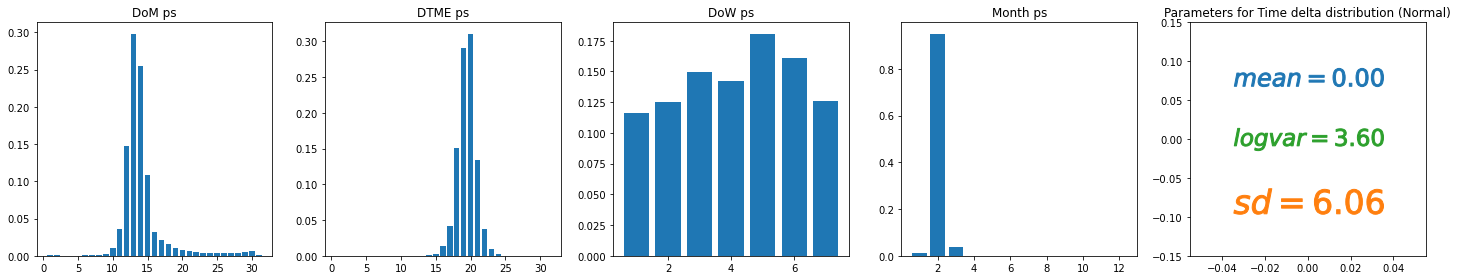

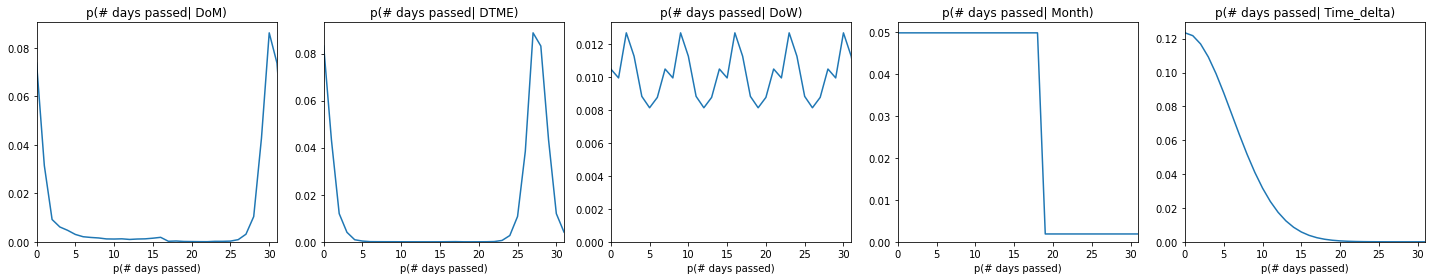

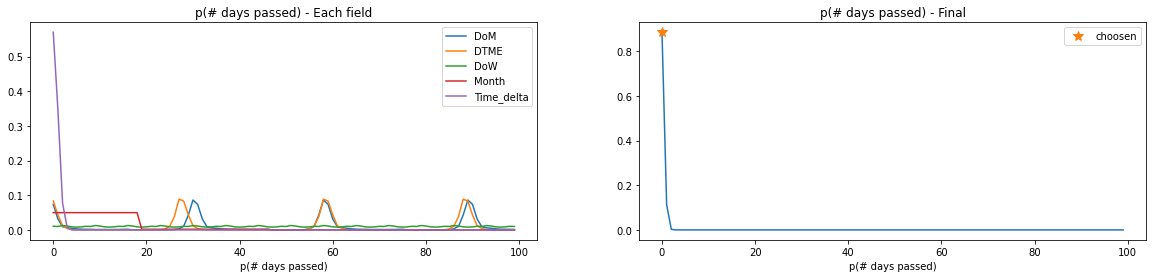





********** Generating element 6 of 20 **********
**Generating k_symbol
Selected INTEREST CREDITED


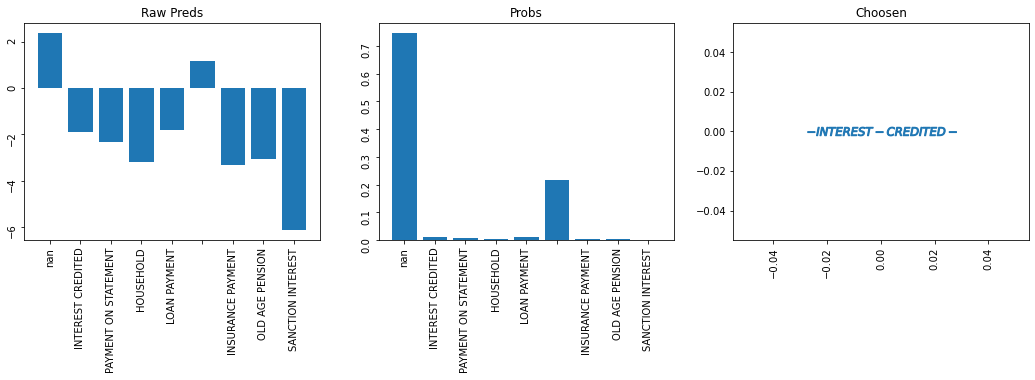

**Generating operation
Selected nan


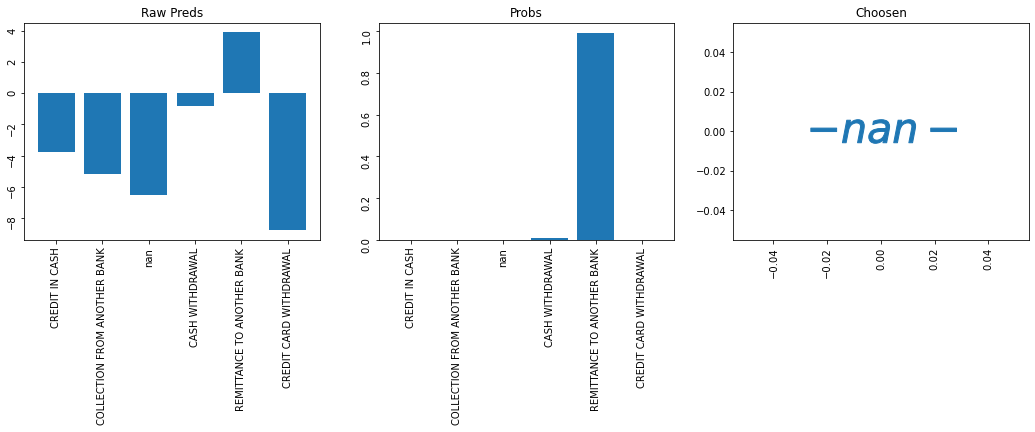

**Generating type
Selected CREDIT


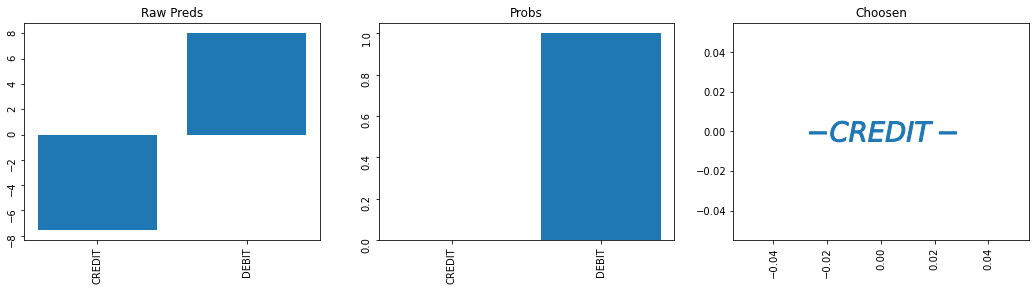

Amount. Unscaled mean = 2.70,	 logvar = 0.00	 sd = 1.00
Sampled value: 2.70
Unscaled value: 732.48



*** Generating next date. Current Date is: 1993-01-13 0




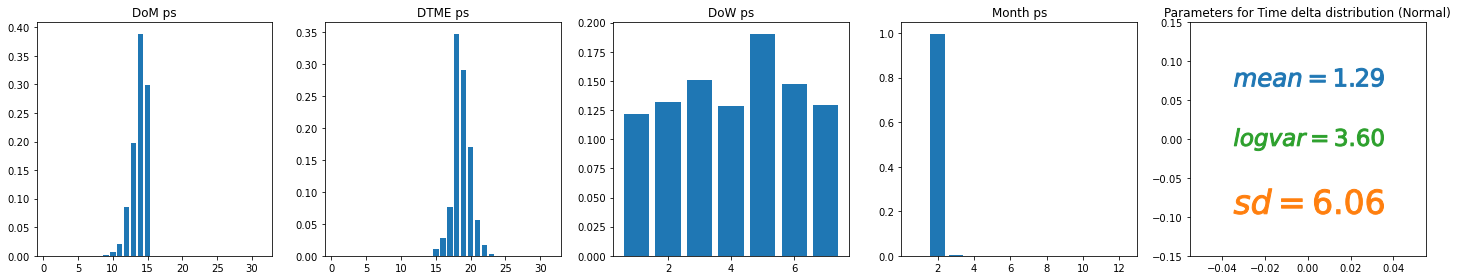

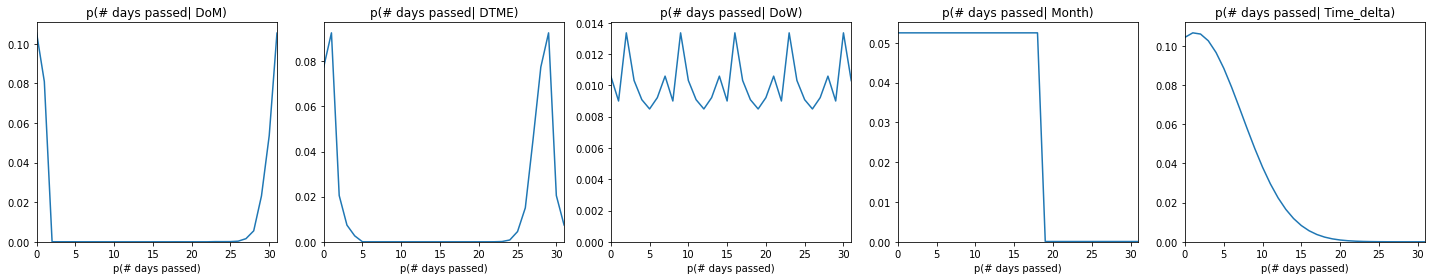

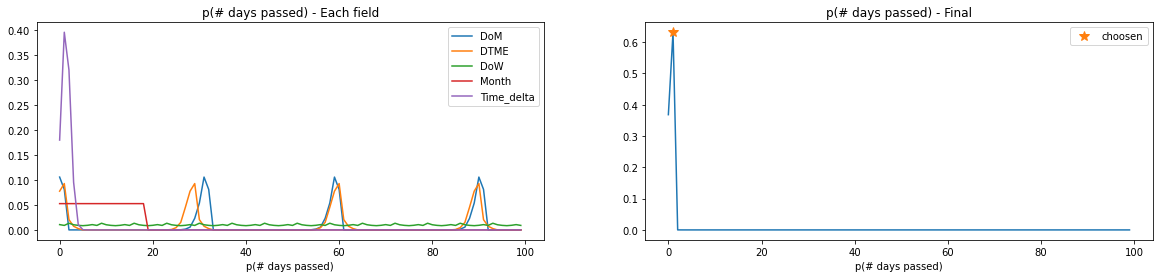





********** Generating element 7 of 20 **********
**Generating k_symbol
Selected nan


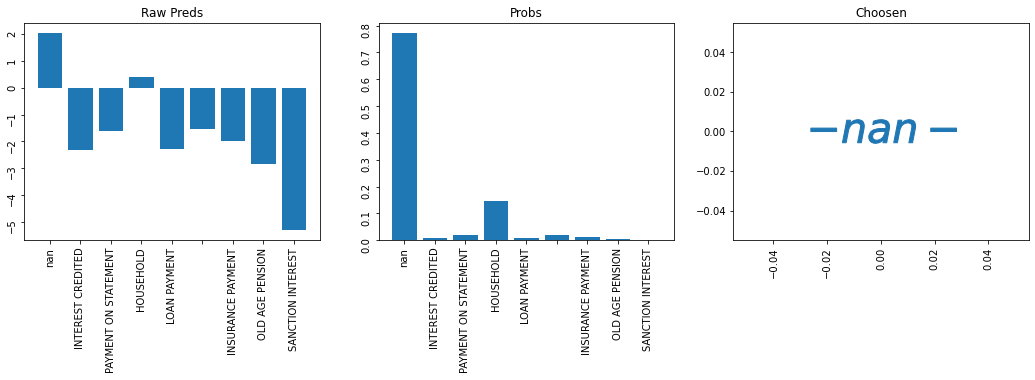

**Generating operation
Selected CREDIT IN CASH


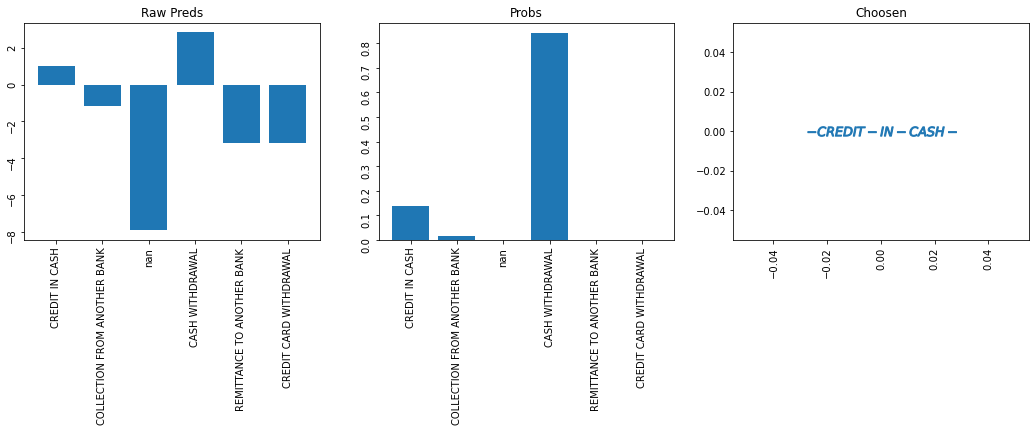

**Generating type
Selected CREDIT


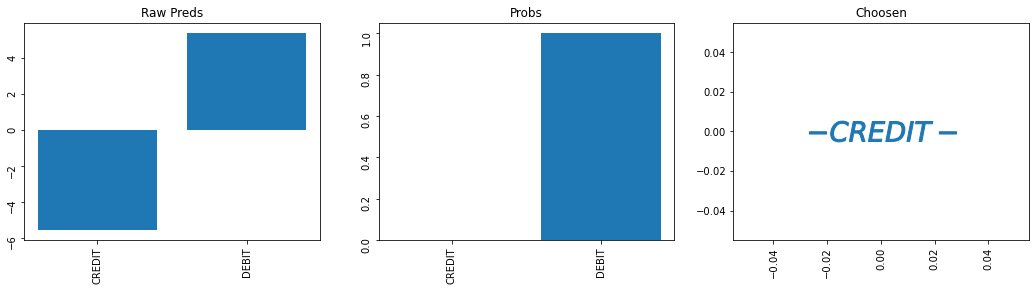

Amount. Unscaled mean = 3.19,	 logvar = 0.00	 sd = 1.00
Sampled value: 3.19
Unscaled value: 2478.09



*** Generating next date. Current Date is: 1993-01-14 0




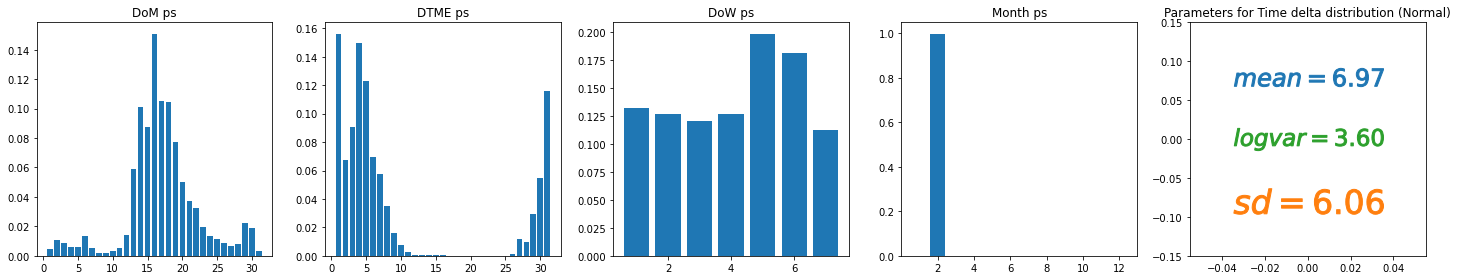

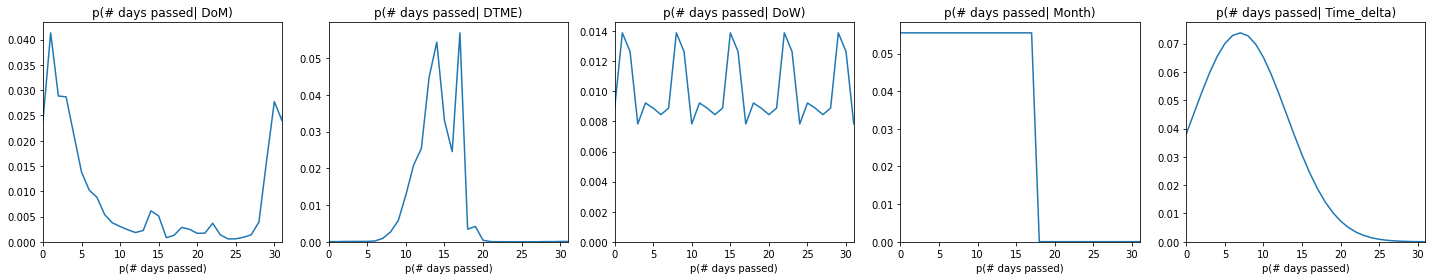

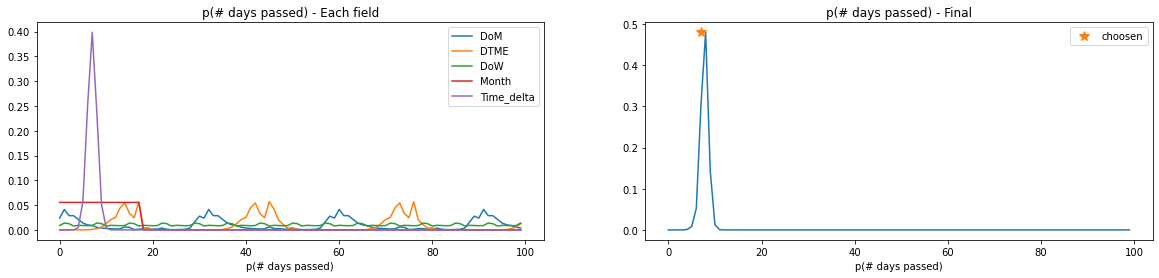





********** Generating element 8 of 20 **********
**Generating k_symbol
Selected PAYMENT ON STATEMENT


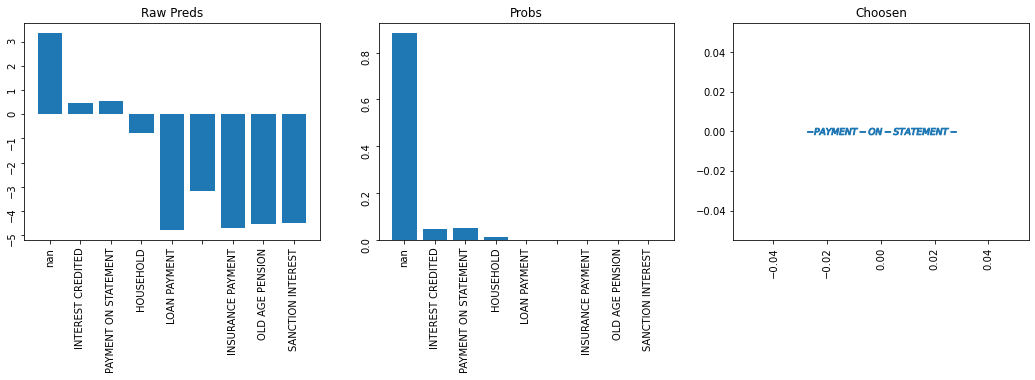

**Generating operation
Selected CASH WITHDRAWAL


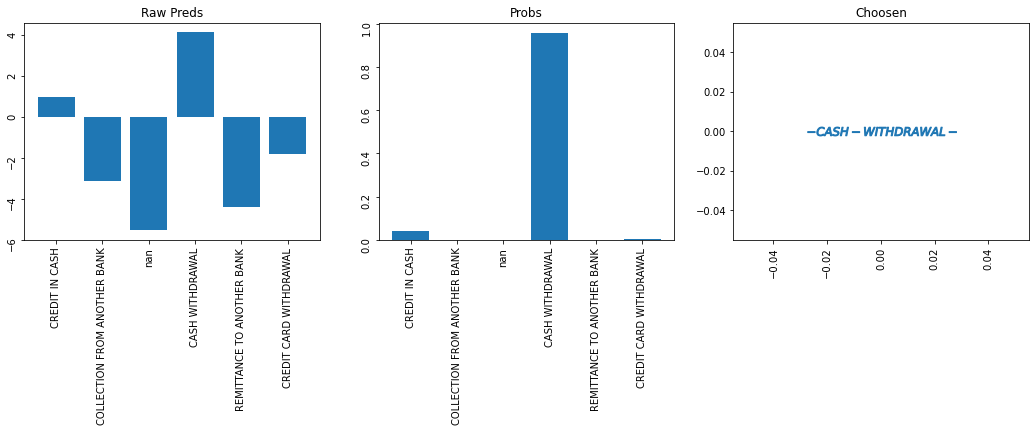

**Generating type
Selected DEBIT


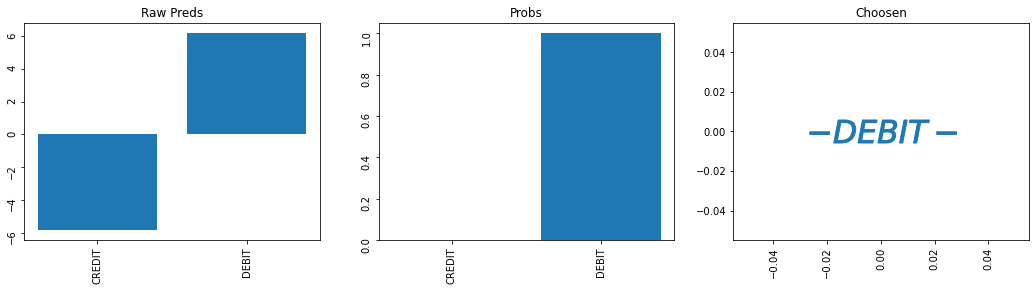

Amount. Unscaled mean = 3.20,	 logvar = 0.00	 sd = 1.00
Sampled value: 3.20
Unscaled value: 2528.44



*** Generating next date. Current Date is: 1993-01-21 0




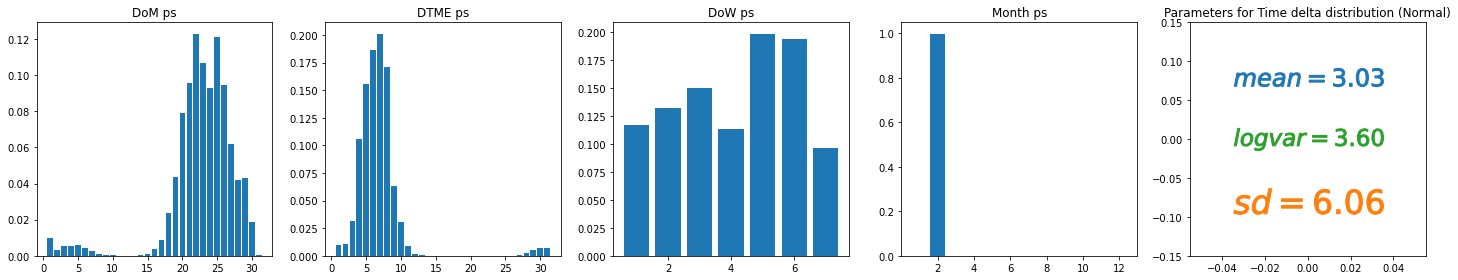

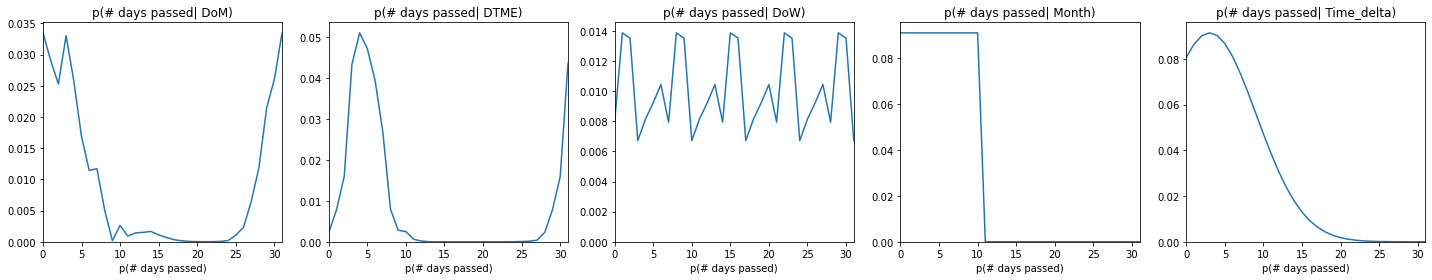

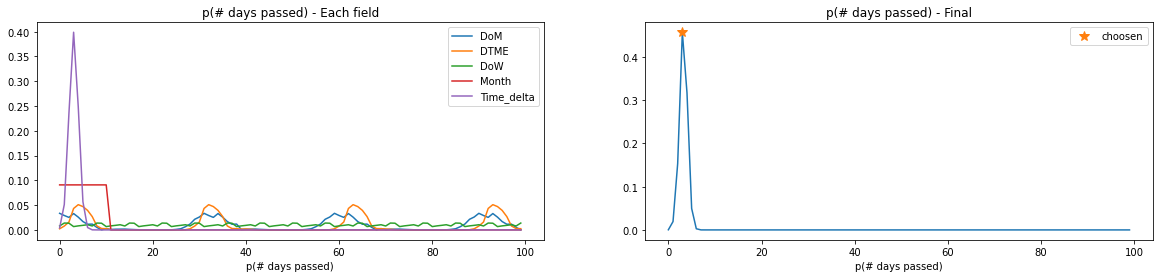





********** Generating element 9 of 20 **********
**Generating k_symbol
Selected nan


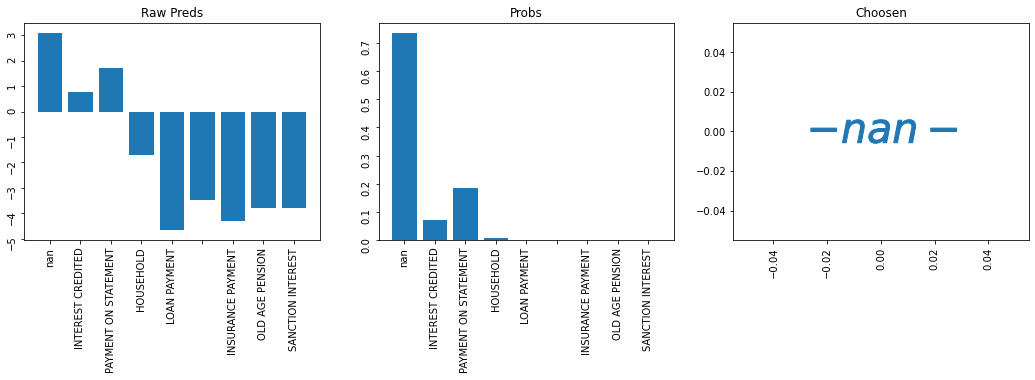

**Generating operation
Selected CASH WITHDRAWAL


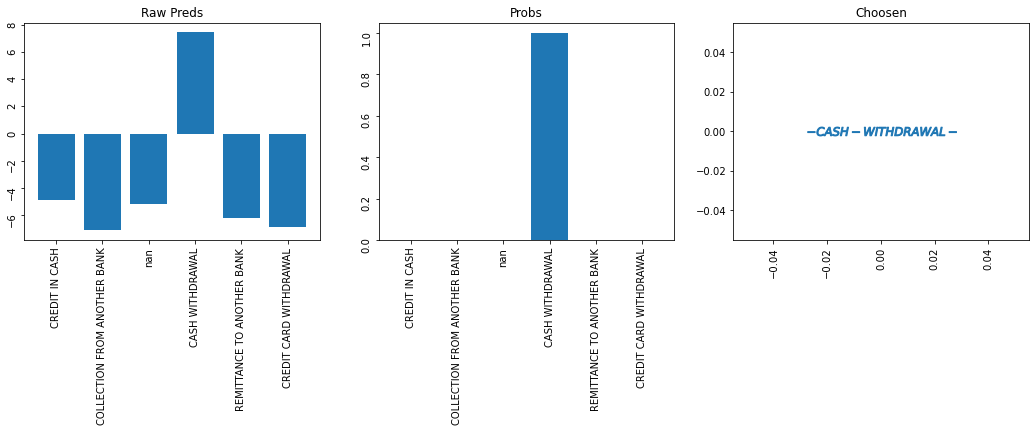

**Generating type
Selected DEBIT


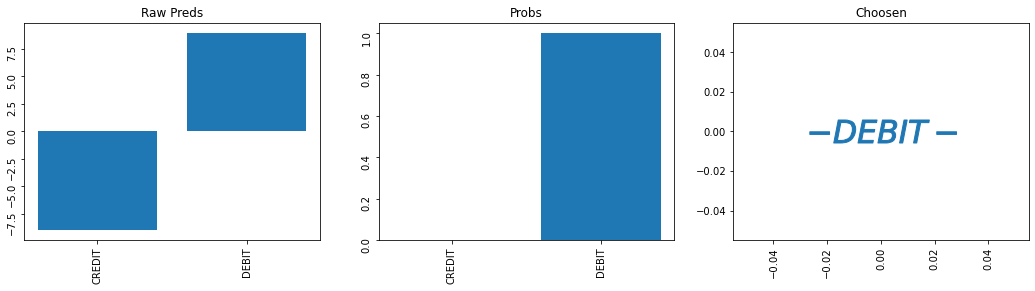

Amount. Unscaled mean = 1.05,	 logvar = 0.00	 sd = 1.00
Sampled value: 1.05
Unscaled value: 12.06



*** Generating next date. Current Date is: 1993-01-24 0




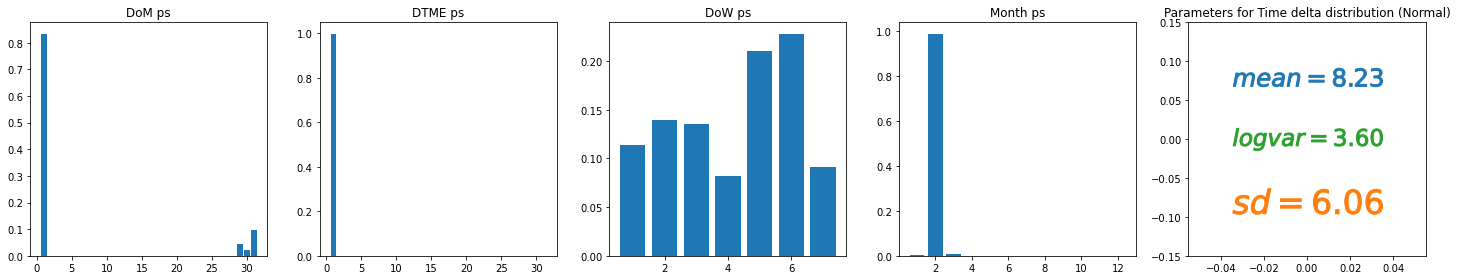

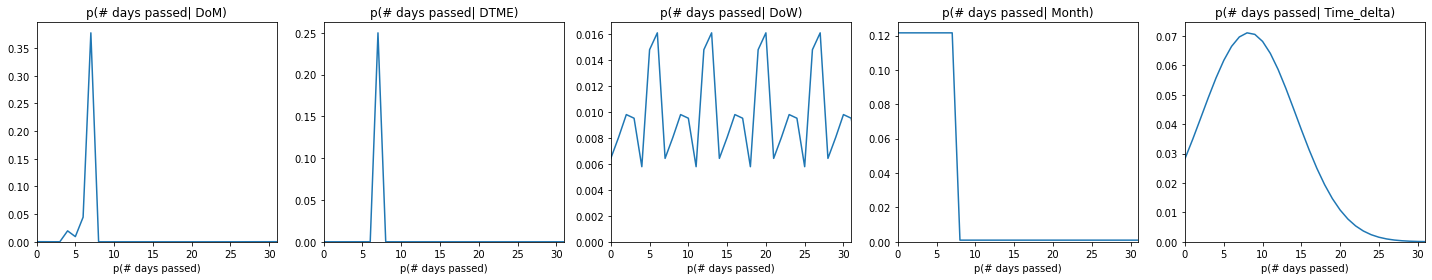

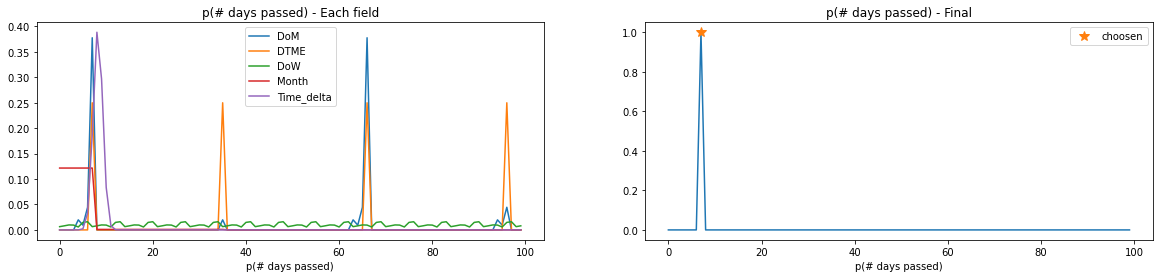





********** Generating element 10 of 20 **********
**Generating k_symbol
Selected nan


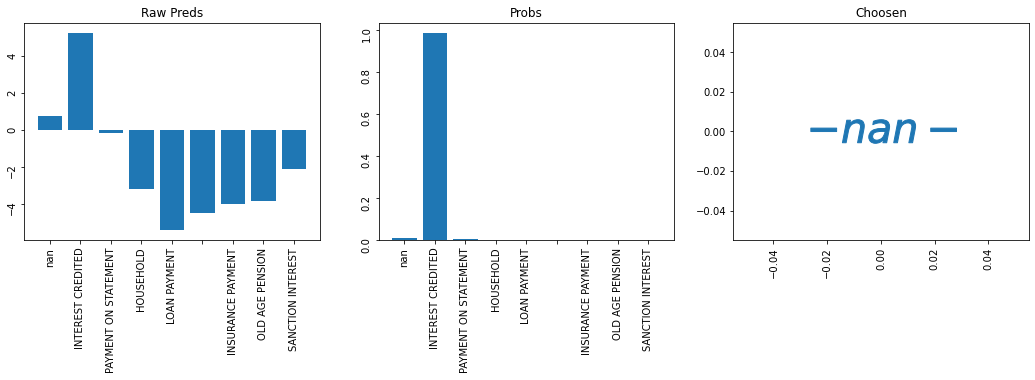

**Generating operation
Selected CREDIT IN CASH


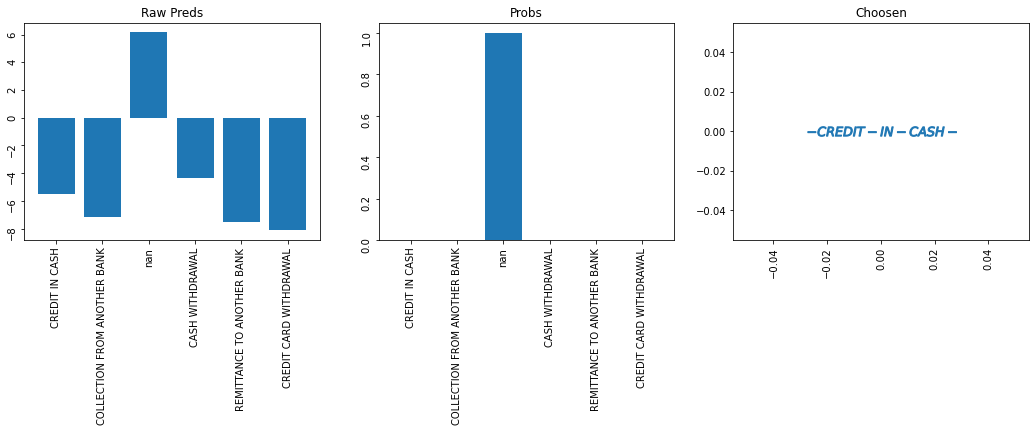

**Generating type
Selected CREDIT


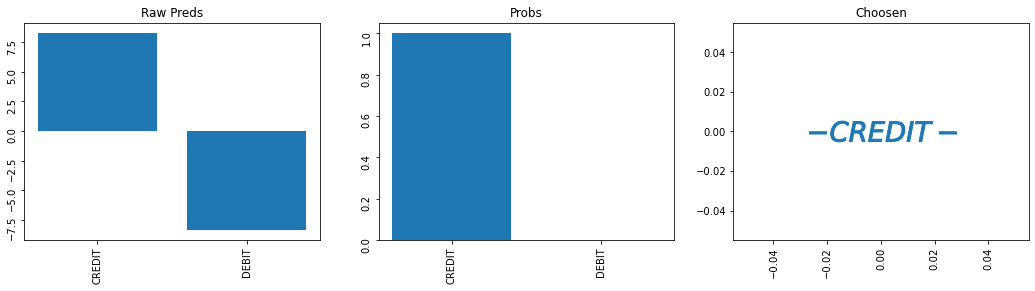

Amount. Unscaled mean = 2.02,	 logvar = 0.00	 sd = 1.00
Sampled value: 2.02
Unscaled value: 139.62



*** Generating next date. Current Date is: 1993-01-31 0




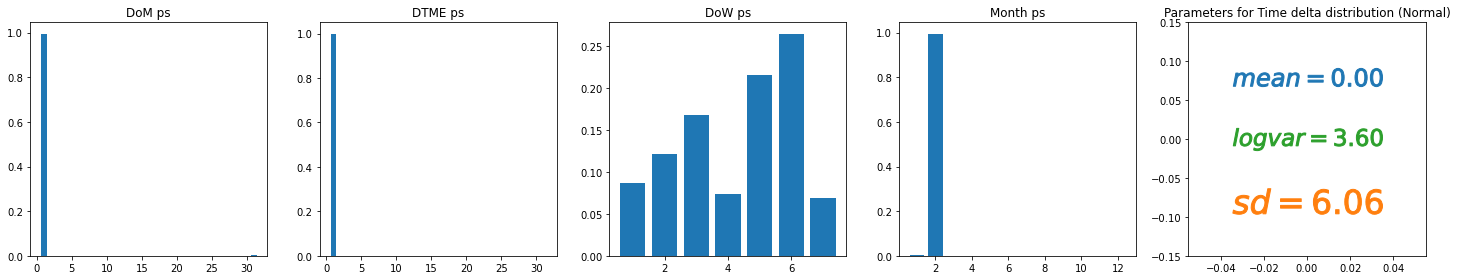

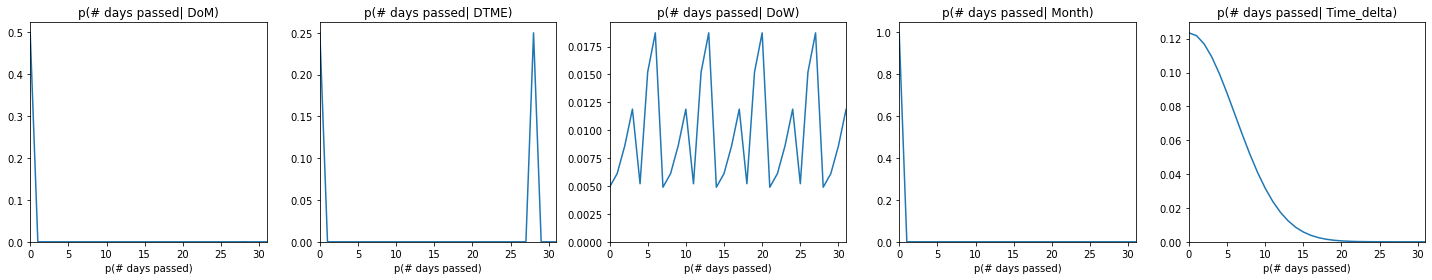

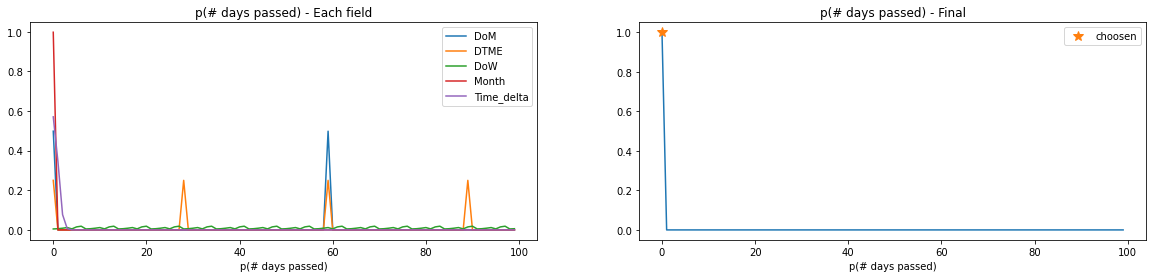





********** Generating element 11 of 20 **********
**Generating k_symbol
Selected INTEREST CREDITED


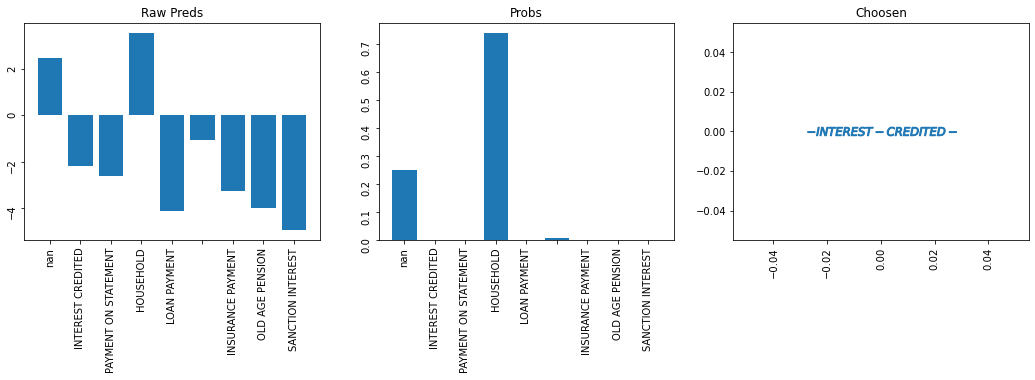

**Generating operation
Selected nan


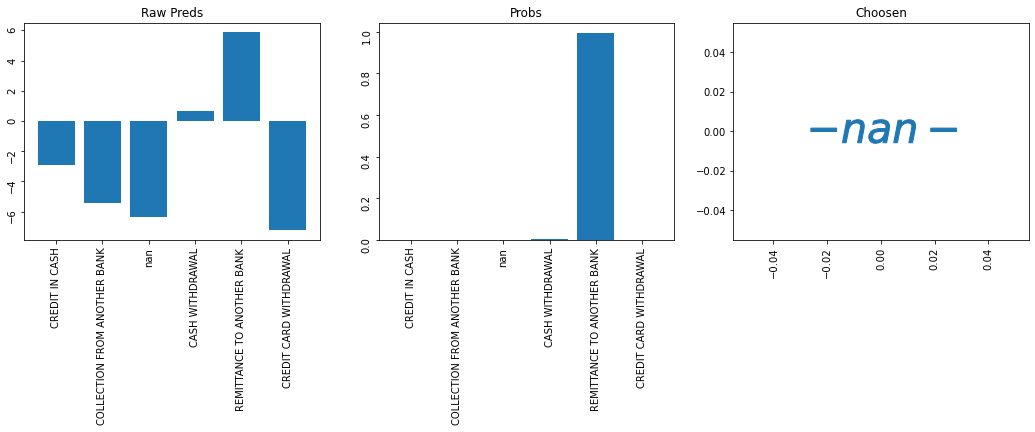

**Generating type
Selected CREDIT


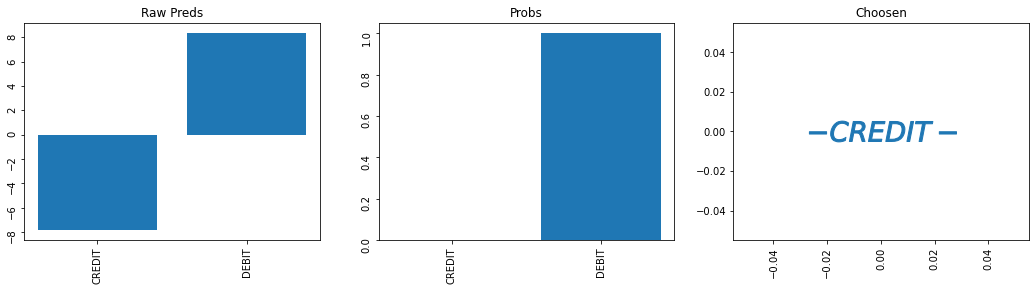

Amount. Unscaled mean = 3.33,	 logvar = 0.00	 sd = 1.00
Sampled value: 3.33
Unscaled value: 3477.45



*** Generating next date. Current Date is: 1993-01-31 0




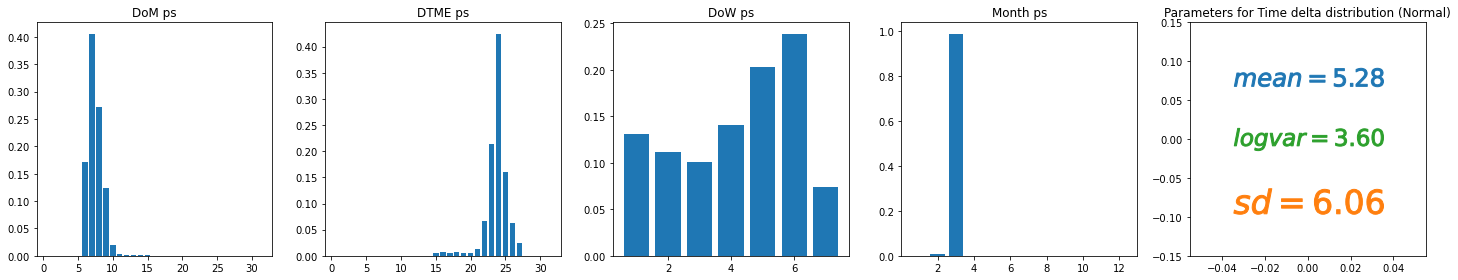

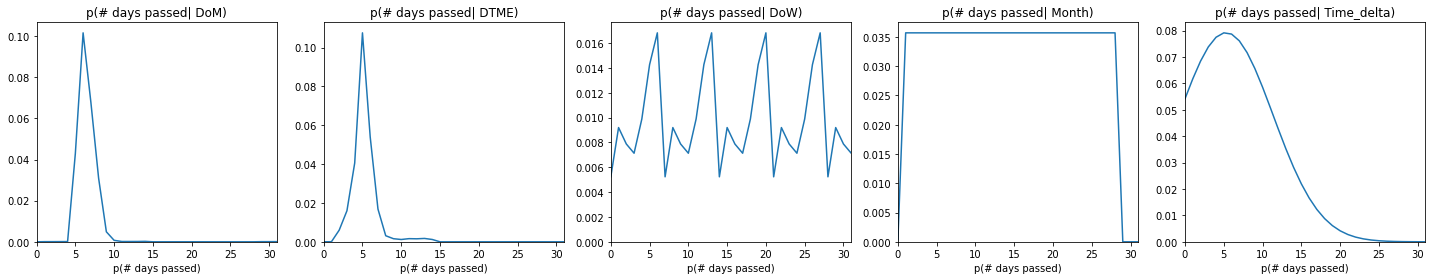

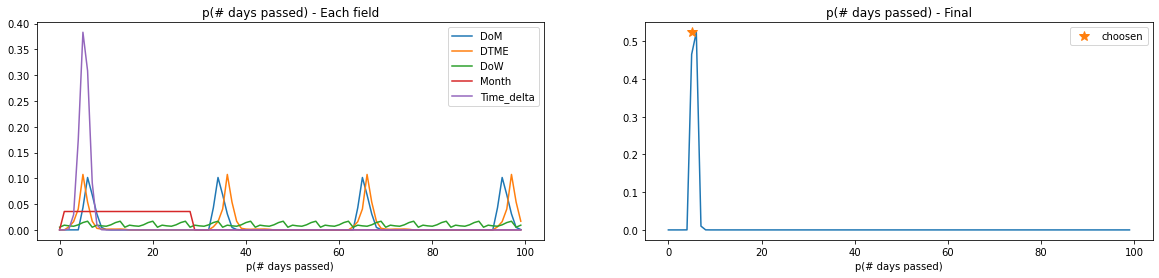





********** Generating element 12 of 20 **********
**Generating k_symbol
Selected HOUSEHOLD


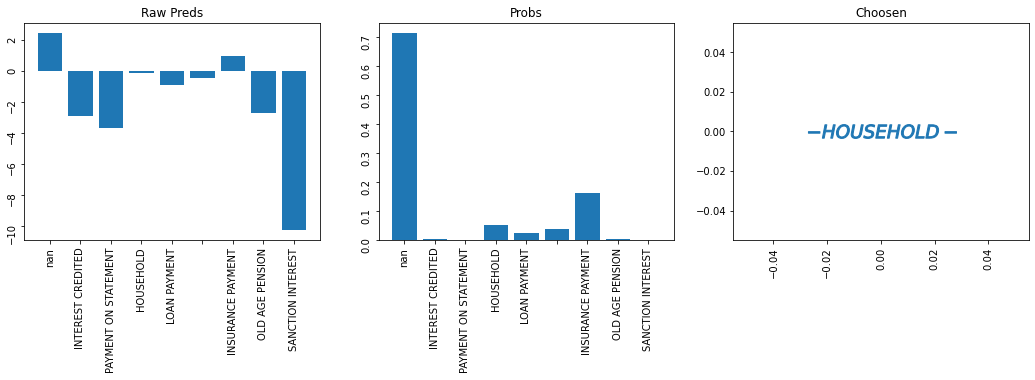

**Generating operation
Selected REMITTANCE TO ANOTHER BANK


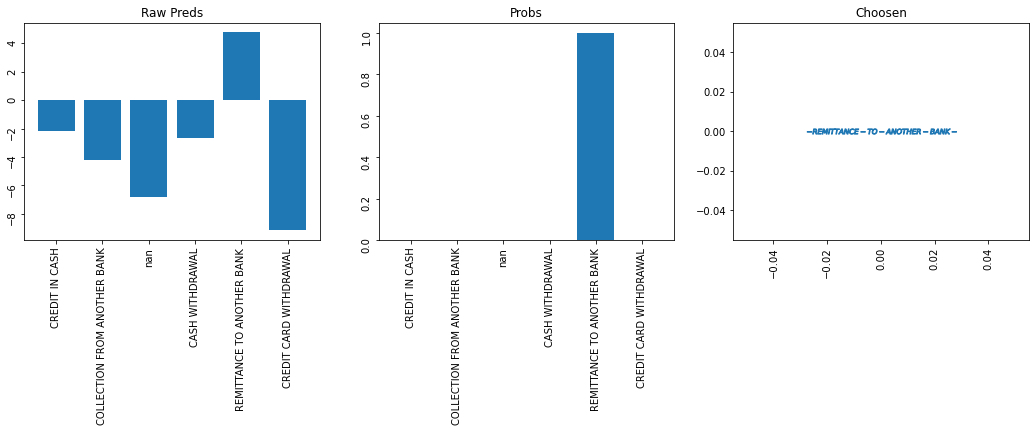

**Generating type
Selected DEBIT


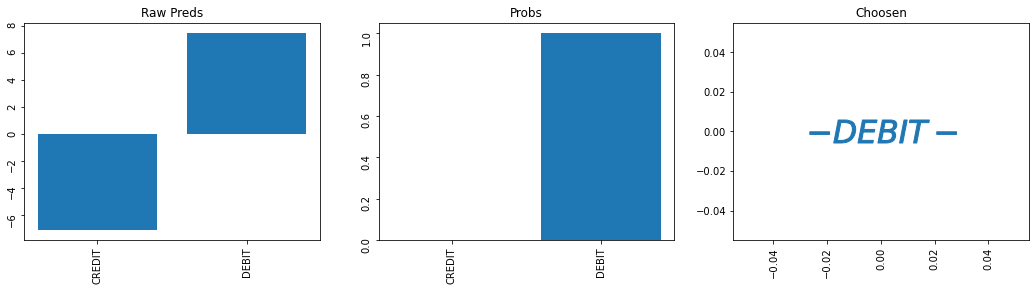

Amount. Unscaled mean = 2.51,	 logvar = 0.00	 sd = 1.00
Sampled value: 2.51
Unscaled value: 462.32



*** Generating next date. Current Date is: 1993-02-05 0




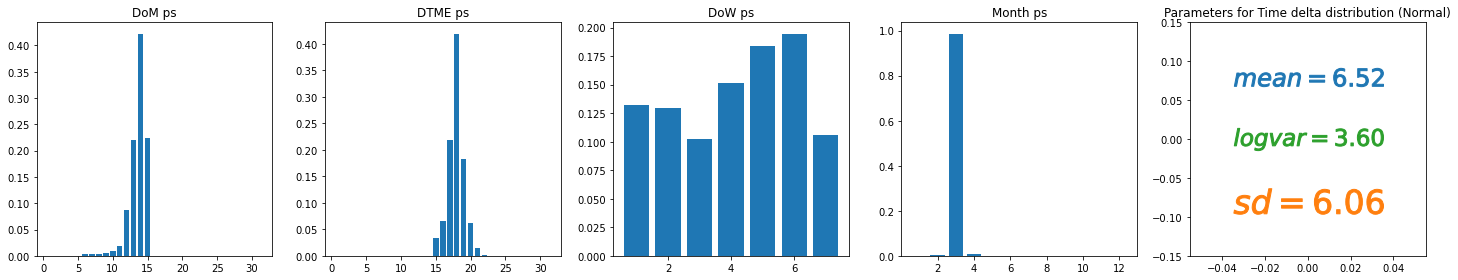

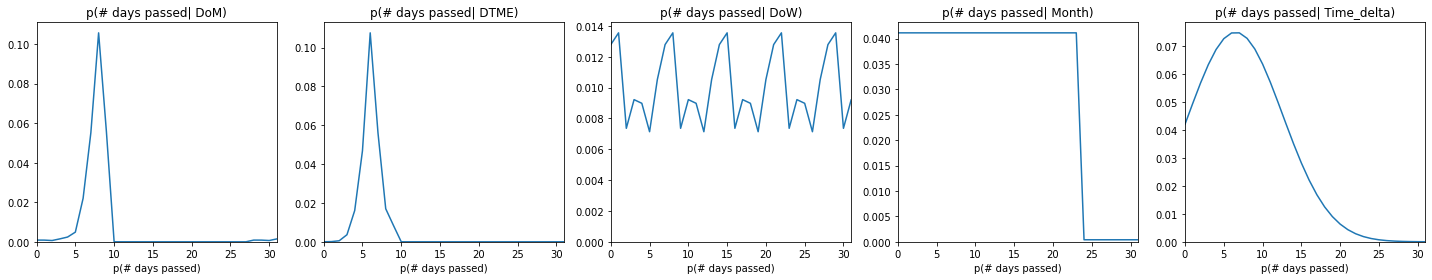

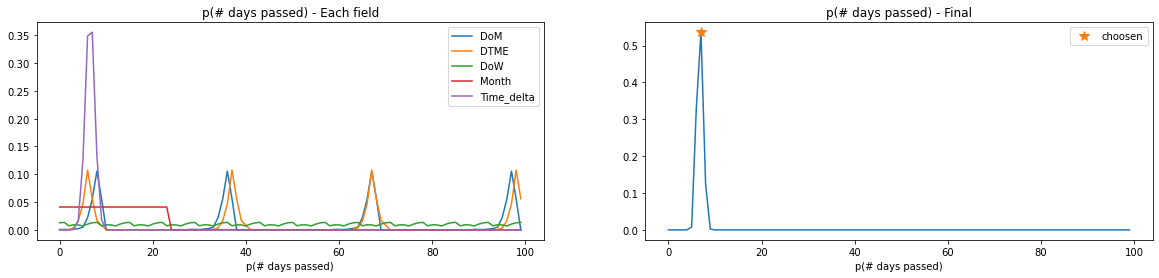





********** Generating element 13 of 20 **********
**Generating k_symbol
Selected nan


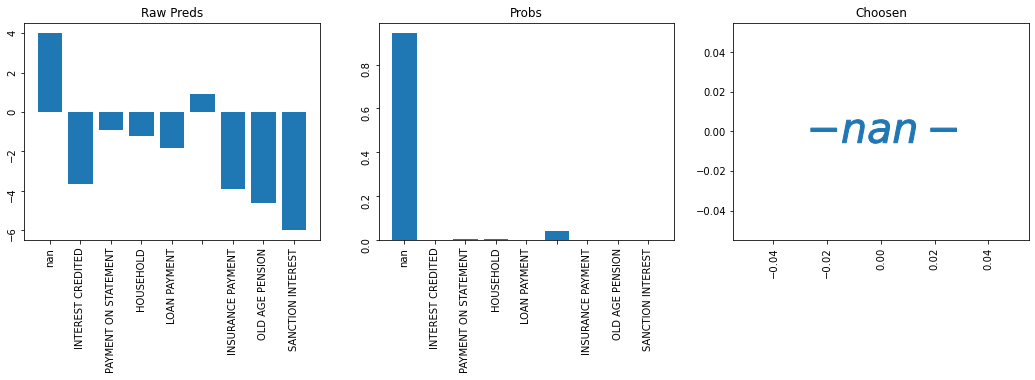

**Generating operation
Selected CASH WITHDRAWAL


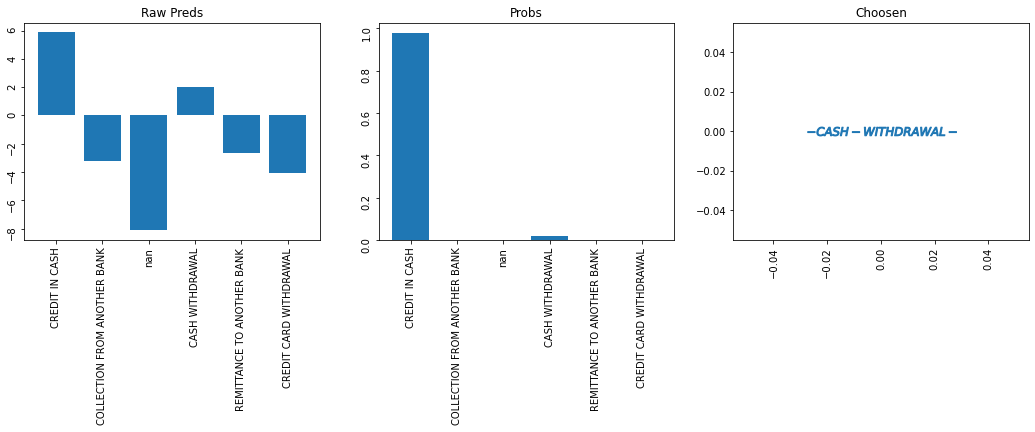

**Generating type
Selected DEBIT


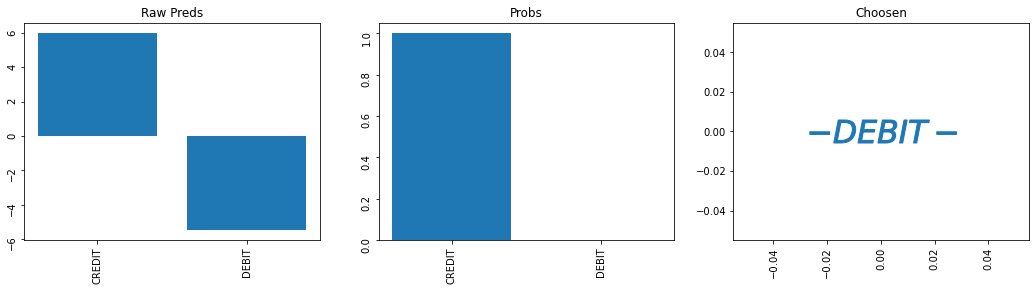

Amount. Unscaled mean = 3.87,	 logvar = 0.00	 sd = 1.00
Sampled value: 3.87
Unscaled value: 12838.63



*** Generating next date. Current Date is: 1993-02-12 0




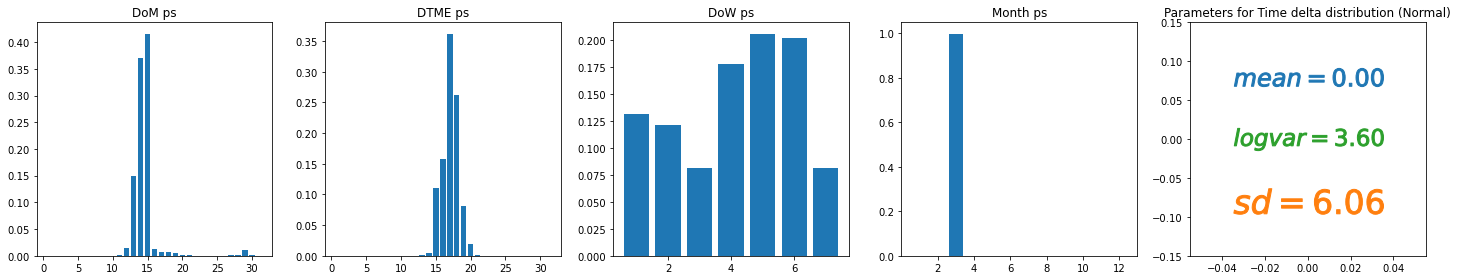

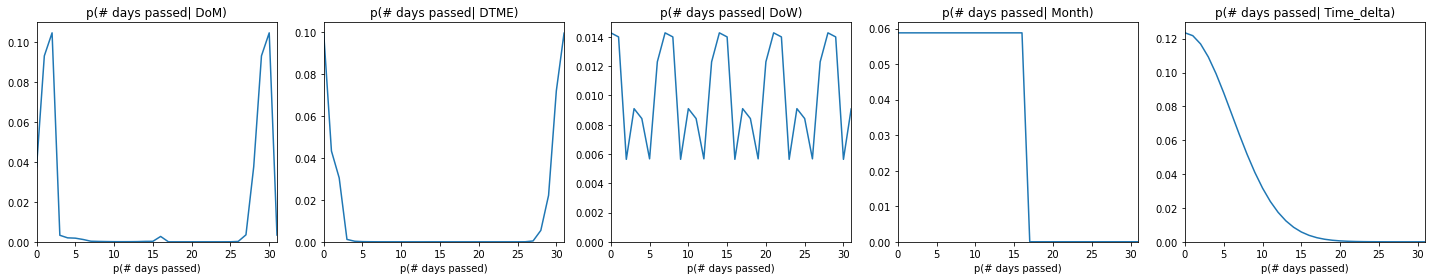

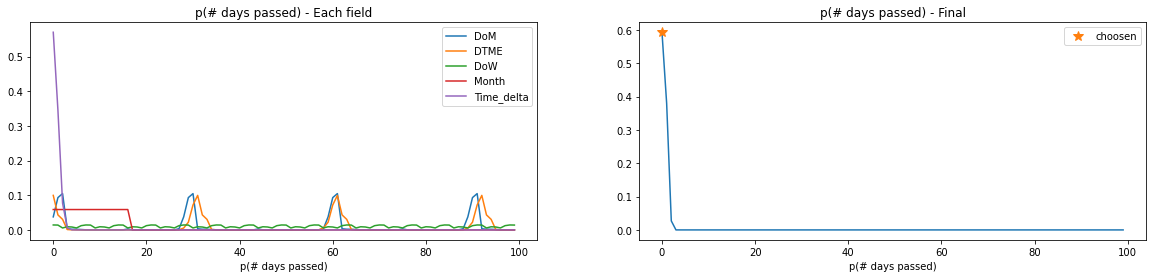





********** Generating element 14 of 20 **********
**Generating k_symbol
Selected HOUSEHOLD


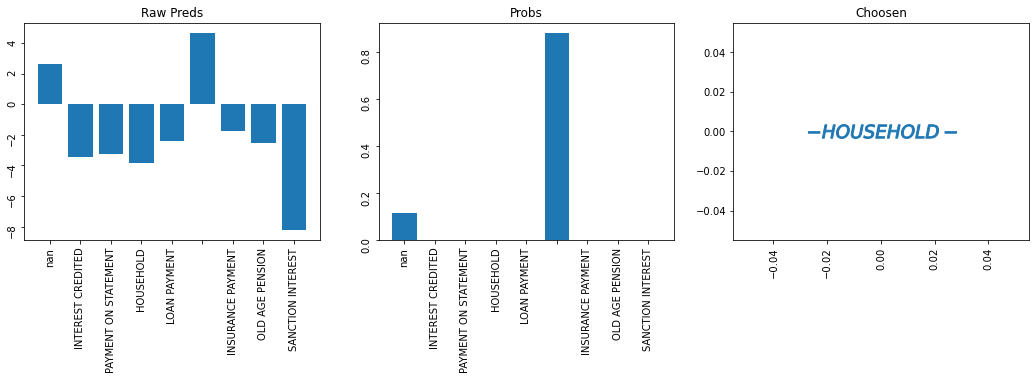

**Generating operation
Selected REMITTANCE TO ANOTHER BANK


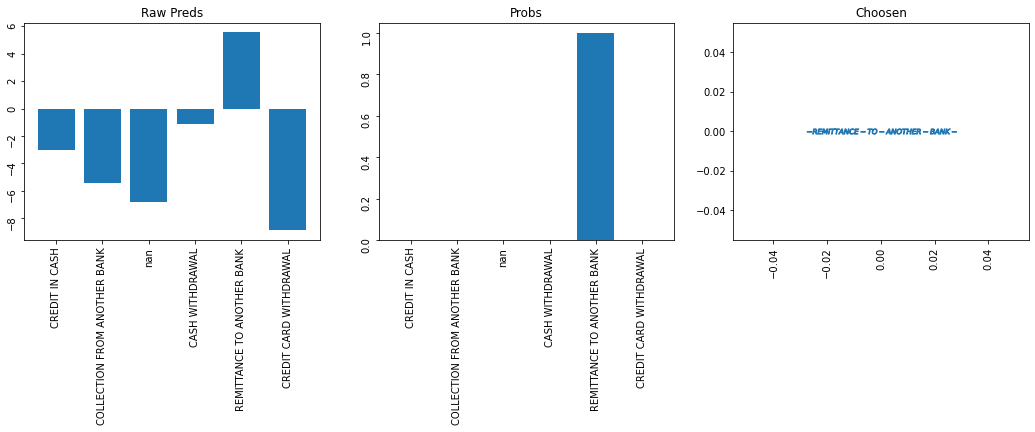

**Generating type
Selected DEBIT


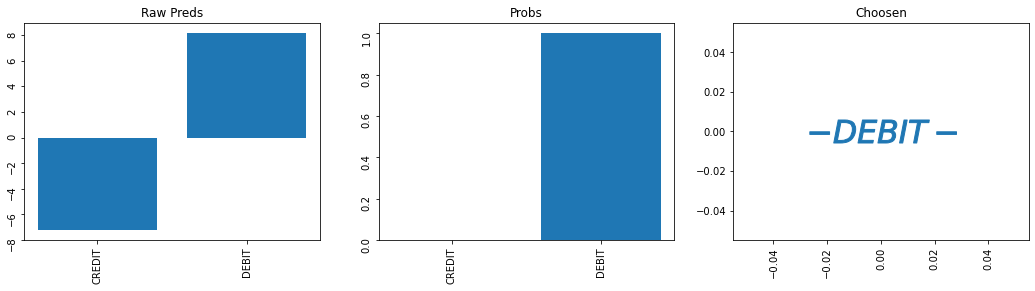

Amount. Unscaled mean = 2.78,	 logvar = 0.00	 sd = 1.00
Sampled value: 2.78
Unscaled value: 904.52



*** Generating next date. Current Date is: 1993-02-12 0




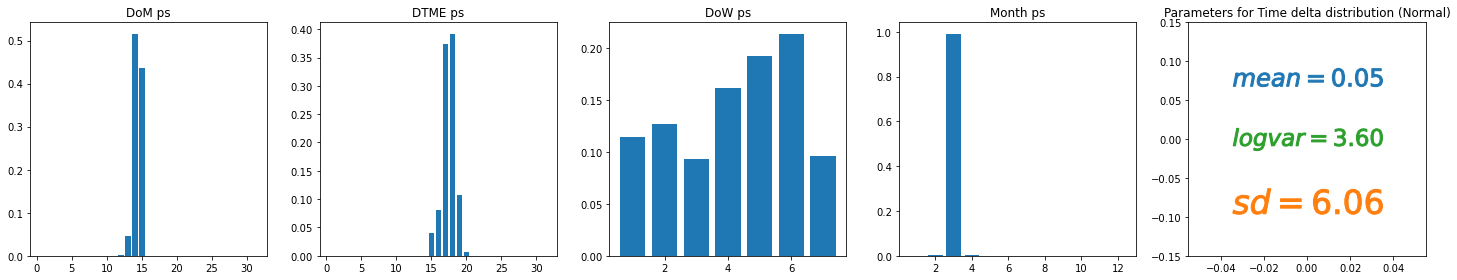

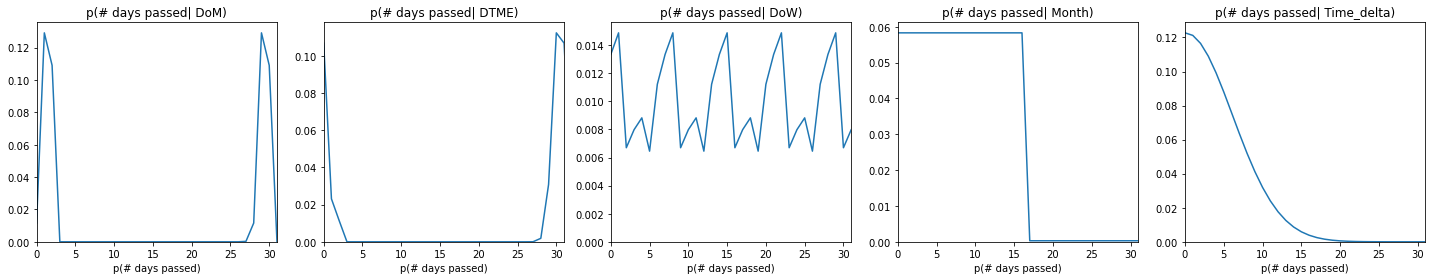

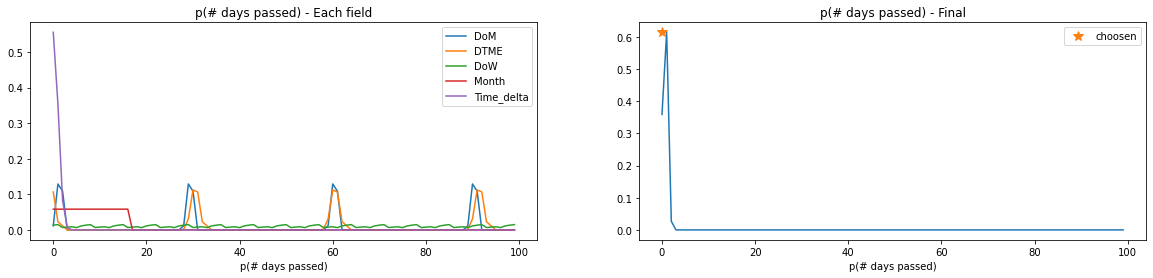





********** Generating element 15 of 20 **********
**Generating k_symbol
Selected nan


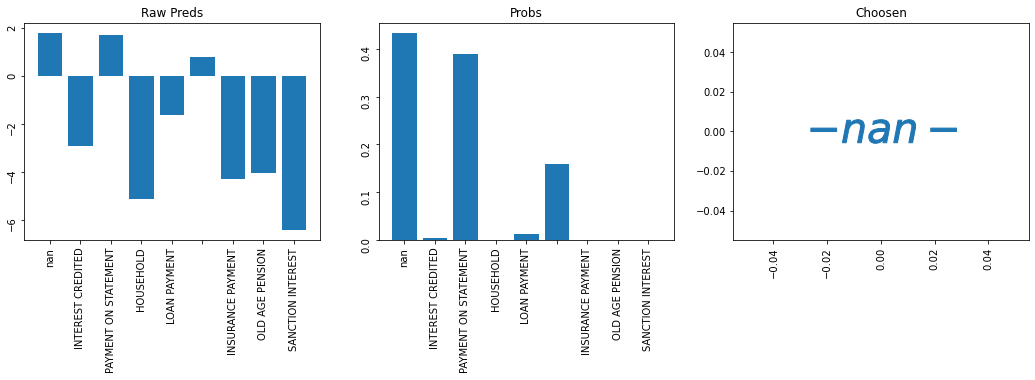

**Generating operation
Selected CASH WITHDRAWAL


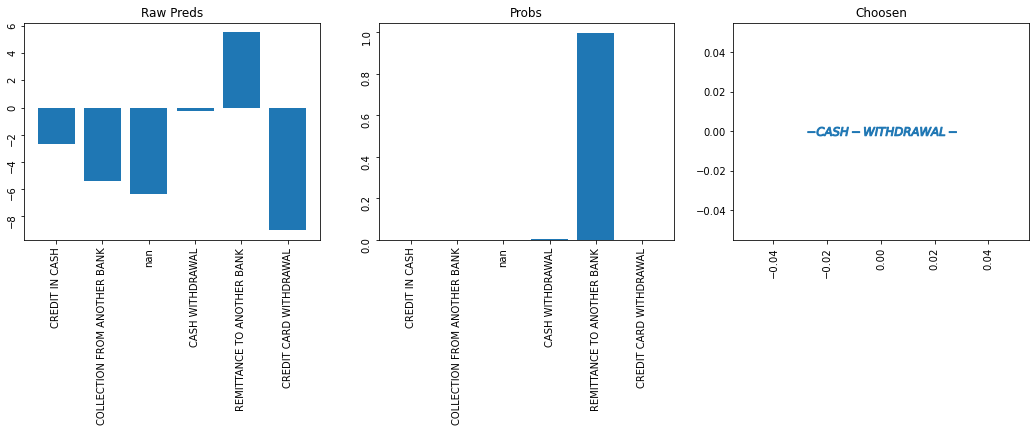

**Generating type
Selected DEBIT


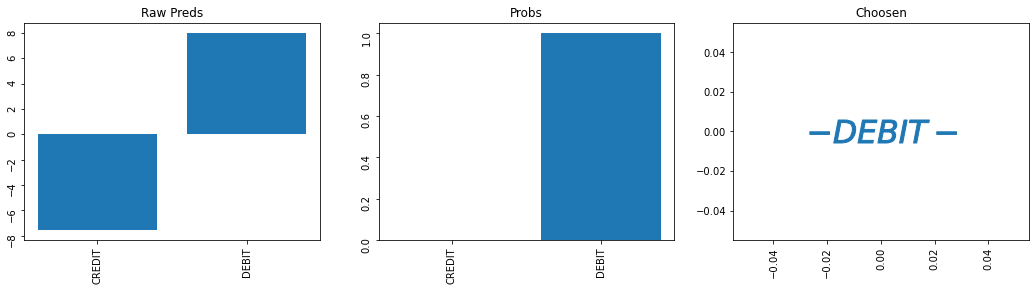

Amount. Unscaled mean = 2.85,	 logvar = 0.00	 sd = 1.00
Sampled value: 2.85
Unscaled value: 1077.92



*** Generating next date. Current Date is: 1993-02-12 0




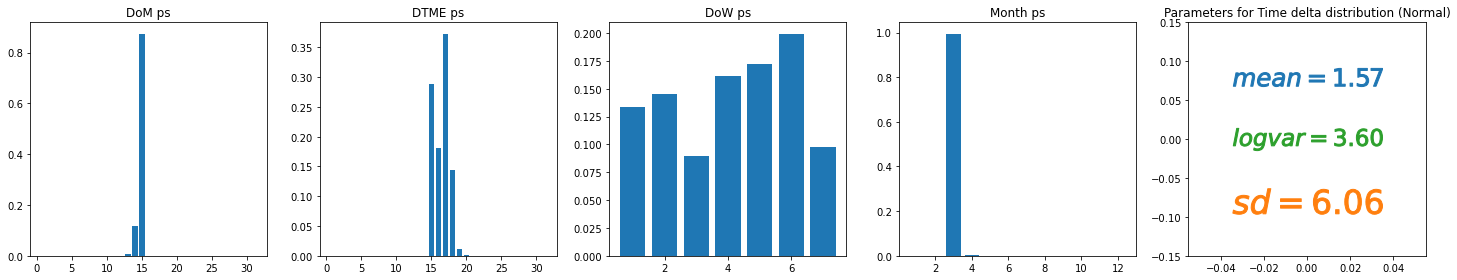

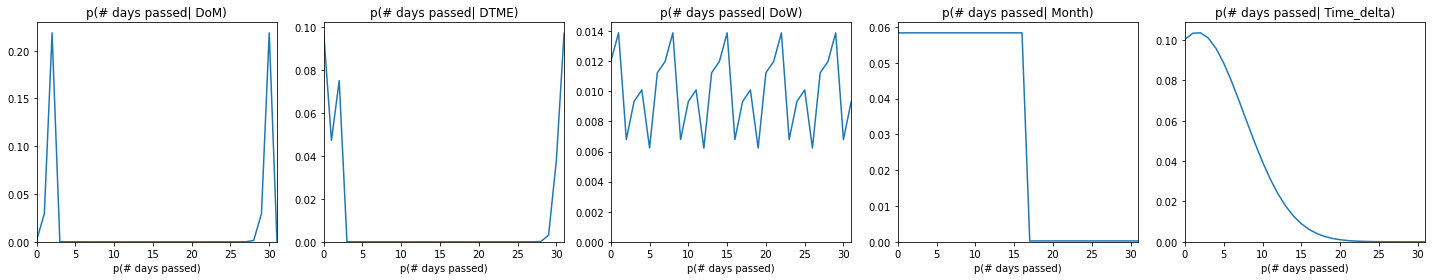

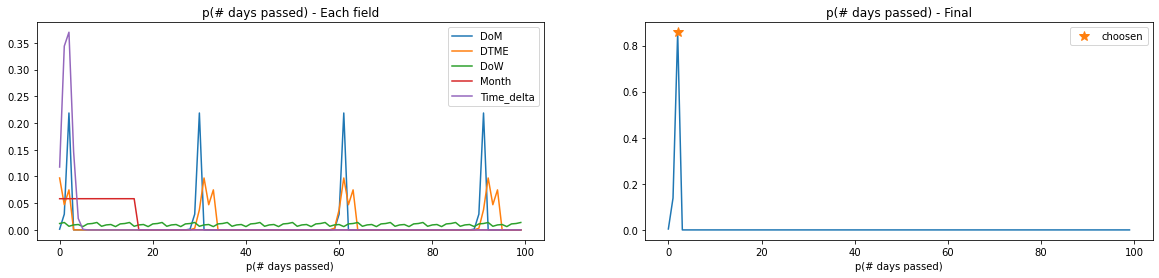





********** Generating element 16 of 20 **********
**Generating k_symbol
Selected nan


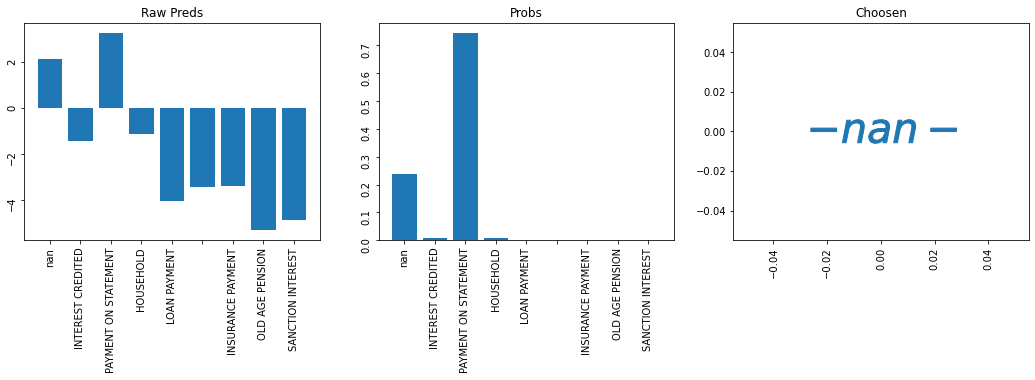

**Generating operation
Selected CASH WITHDRAWAL


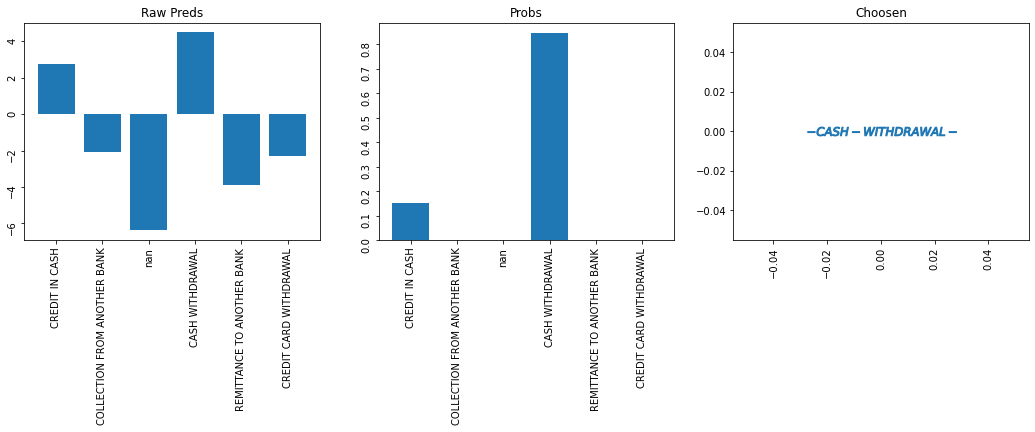

**Generating type
Selected DEBIT


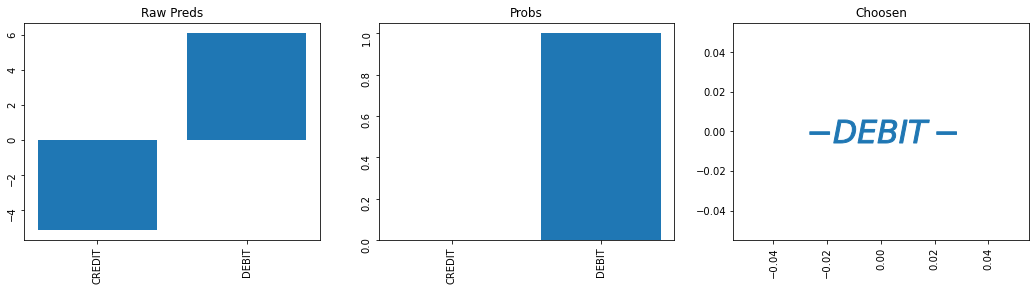

Amount. Unscaled mean = 3.38,	 logvar = 0.00	 sd = 1.00
Sampled value: 3.38
Unscaled value: 3909.21



*** Generating next date. Current Date is: 1993-02-14 0




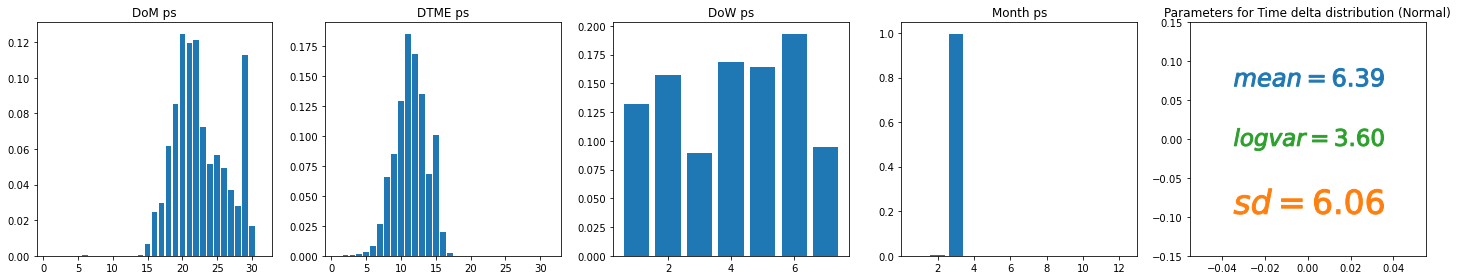

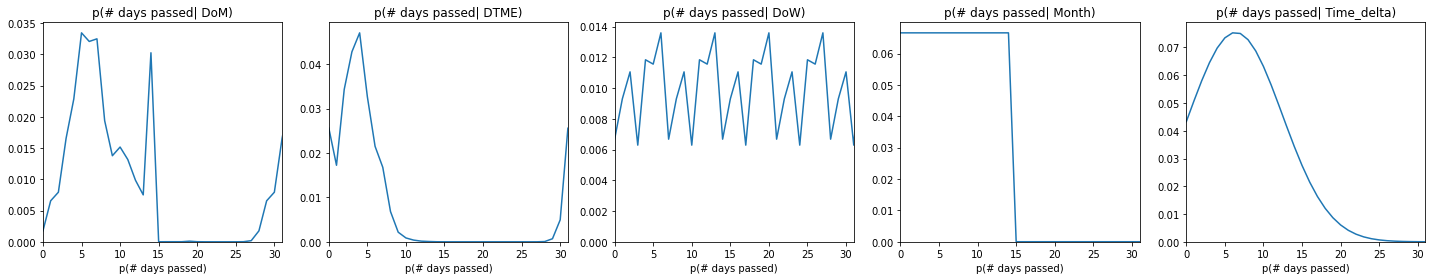

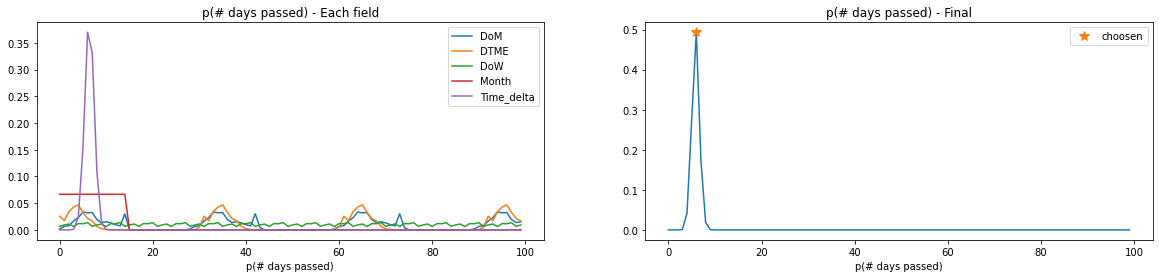





********** Generating element 17 of 20 **********
**Generating k_symbol
Selected nan


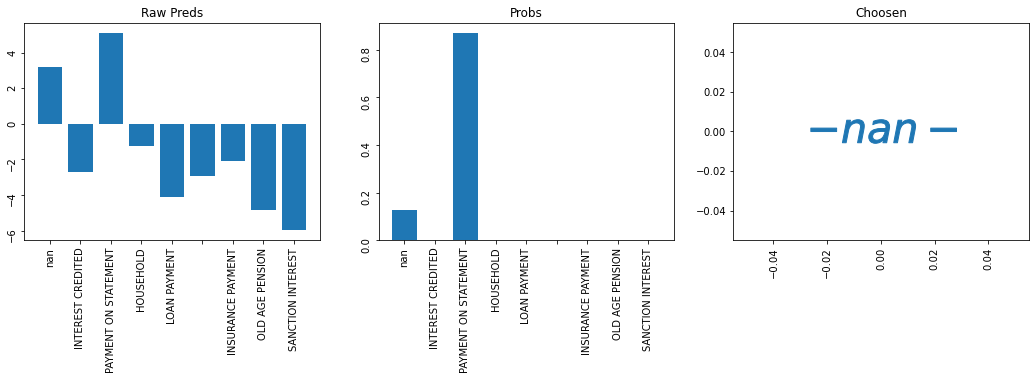

**Generating operation
Selected COLLECTION FROM ANOTHER BANK


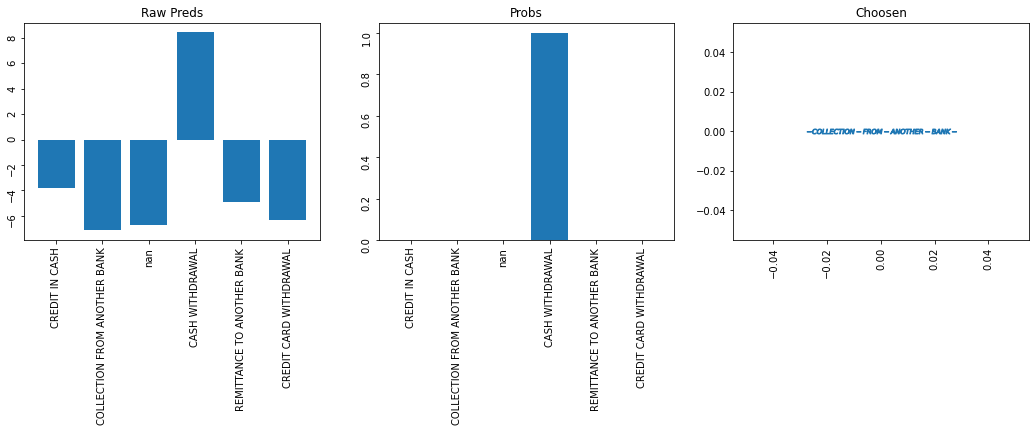

**Generating type
Selected CREDIT


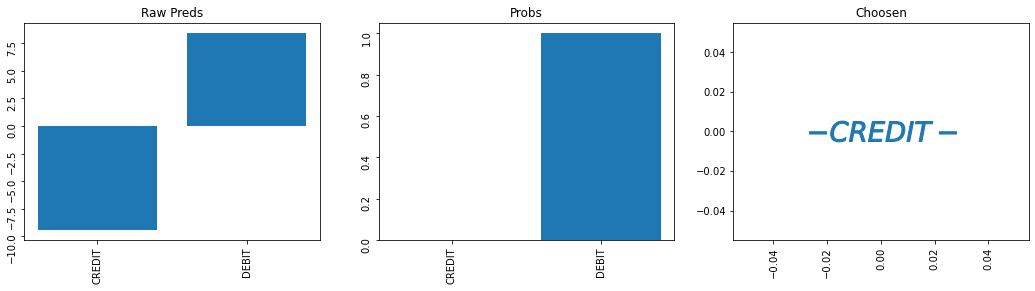

Amount. Unscaled mean = 1.14,	 logvar = 0.00	 sd = 1.00
Sampled value: 1.14
Unscaled value: 15.26



*** Generating next date. Current Date is: 1993-02-20 0




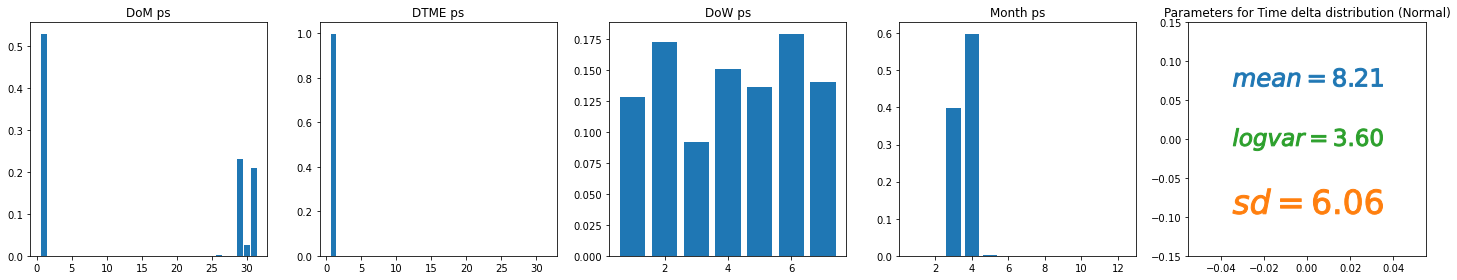

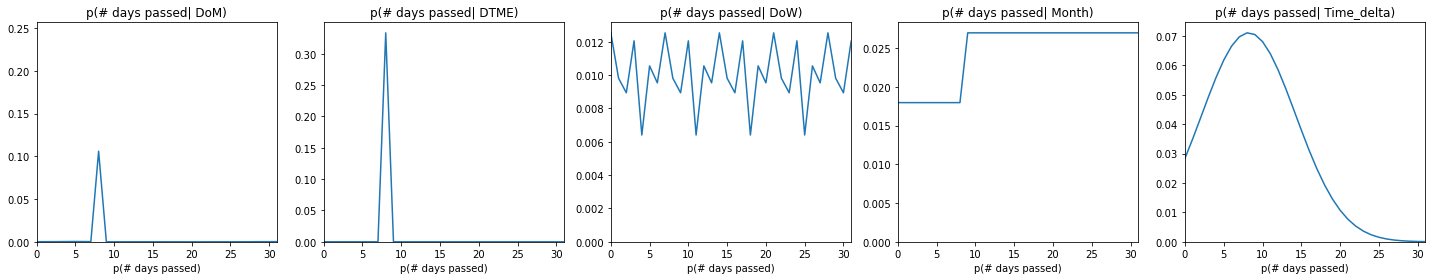

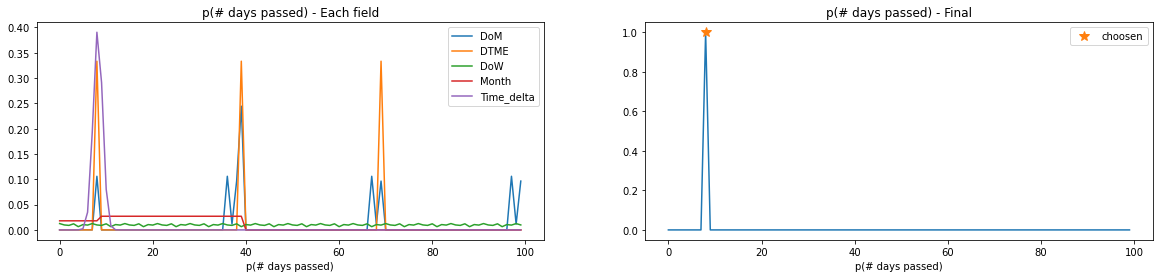





********** Generating element 18 of 20 **********
**Generating k_symbol
Selected OLD AGE PENSION


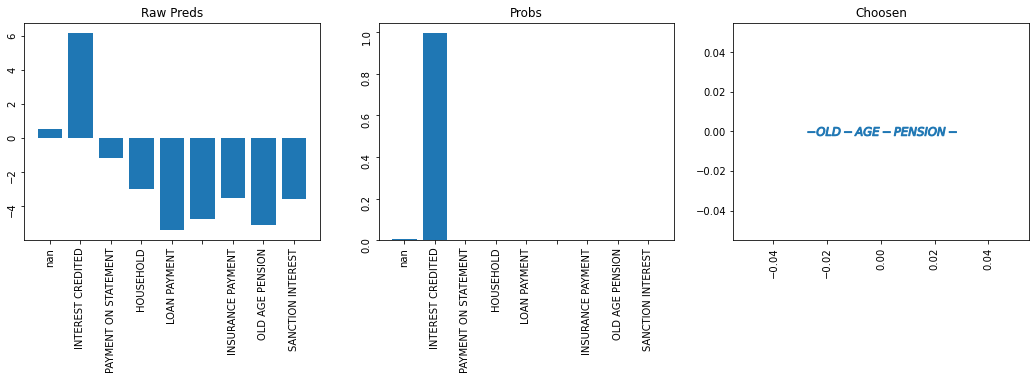

**Generating operation
Selected COLLECTION FROM ANOTHER BANK


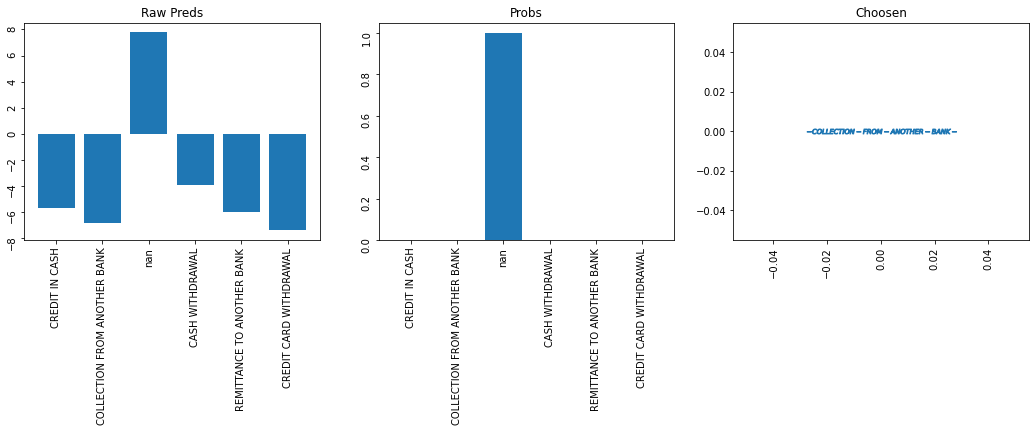

**Generating type
Selected CREDIT


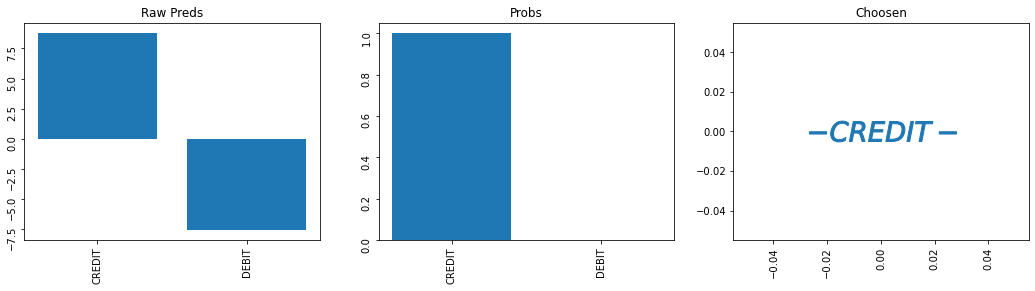

Amount. Unscaled mean = 2.07,	 logvar = 0.00	 sd = 1.00
Sampled value: 2.07
Unscaled value: 157.56



*** Generating next date. Current Date is: 1993-02-28 0




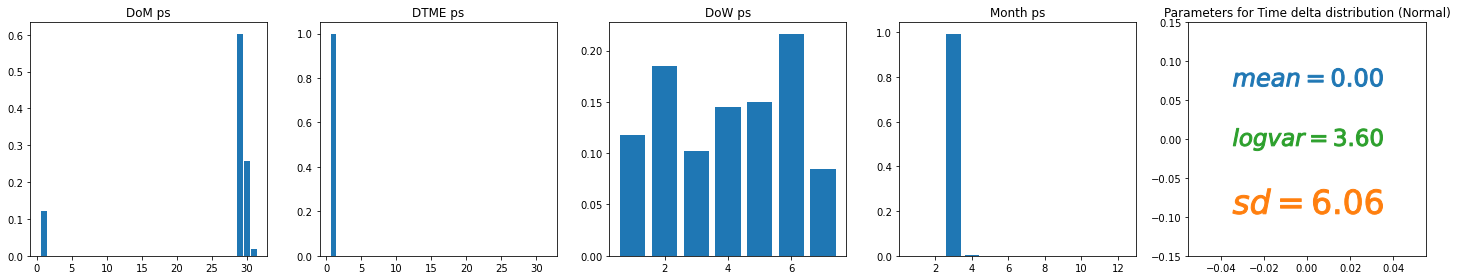

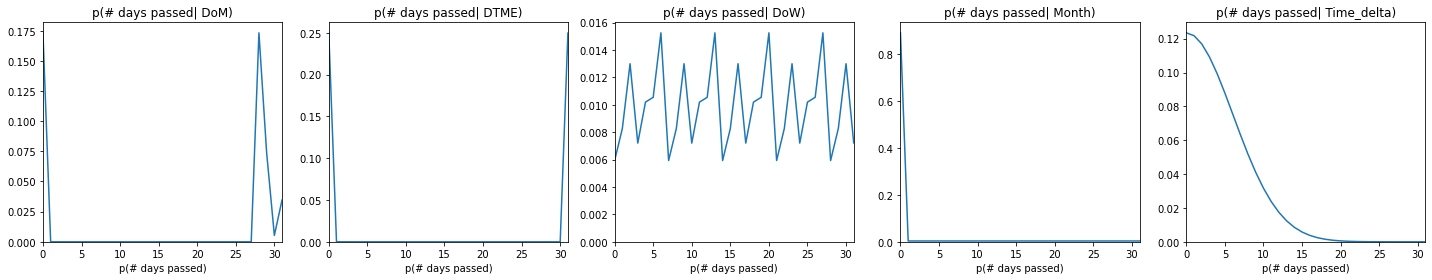

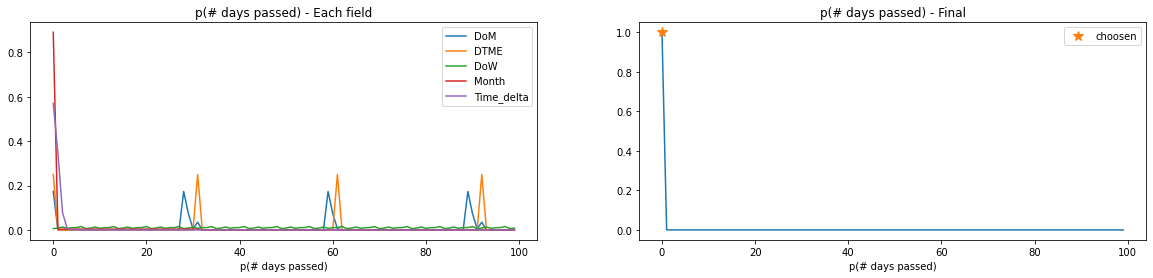





********** Generating element 19 of 20 **********
**Generating k_symbol
Selected HOUSEHOLD


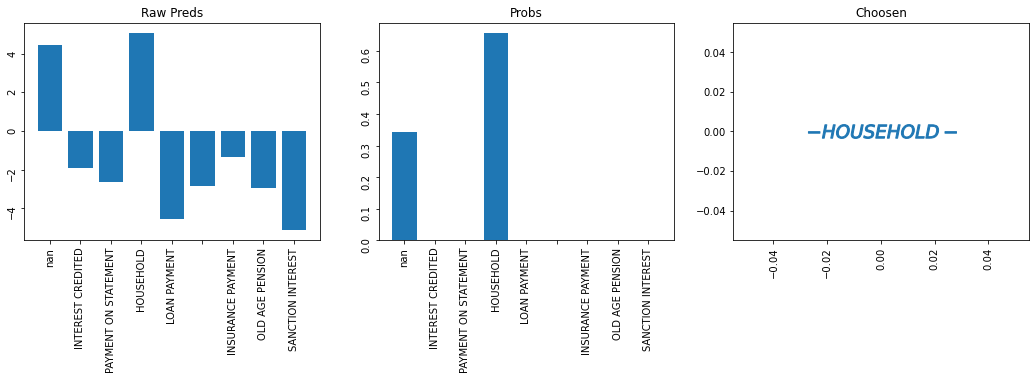

**Generating operation
Selected REMITTANCE TO ANOTHER BANK


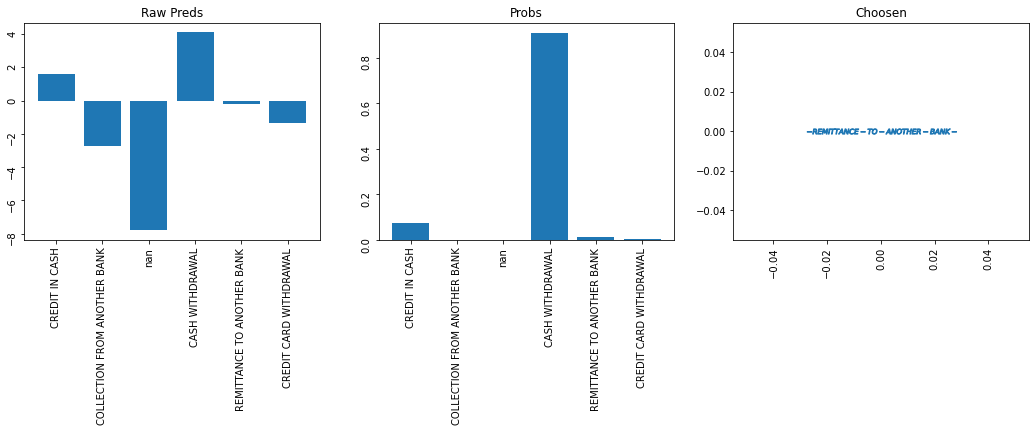

**Generating type
Selected DEBIT


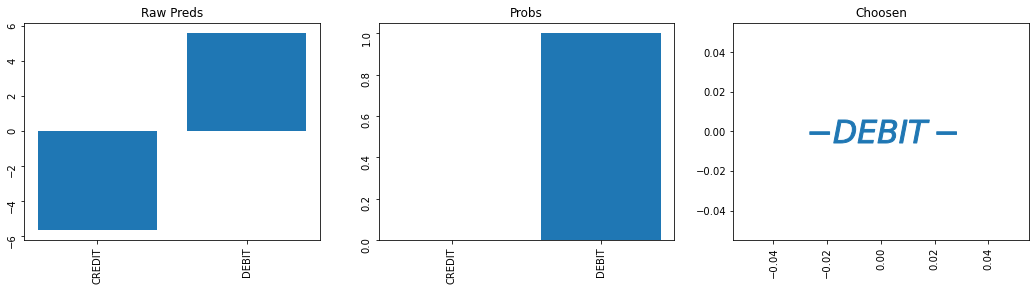

Amount. Unscaled mean = 3.55,	 logvar = 0.00	 sd = 1.00
Sampled value: 3.55
Unscaled value: 5894.88



*** Generating next date. Current Date is: 1993-02-28 0




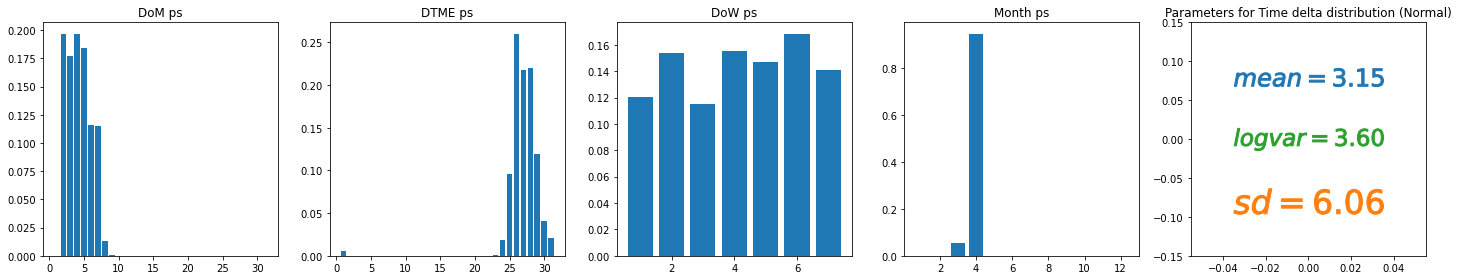

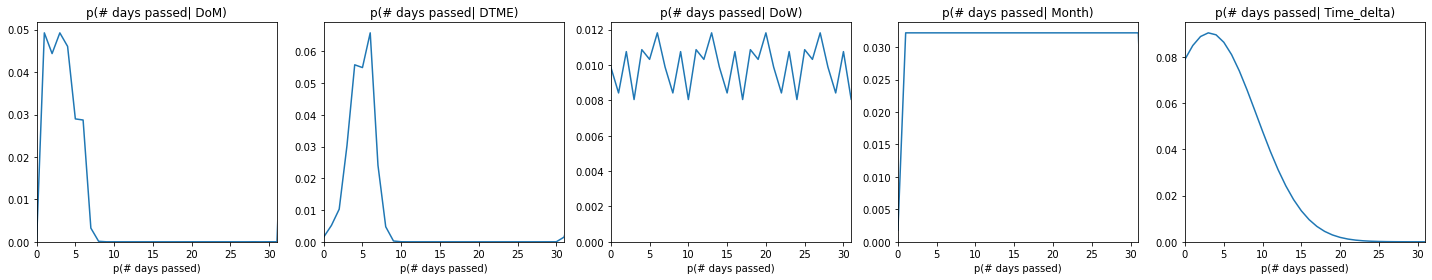

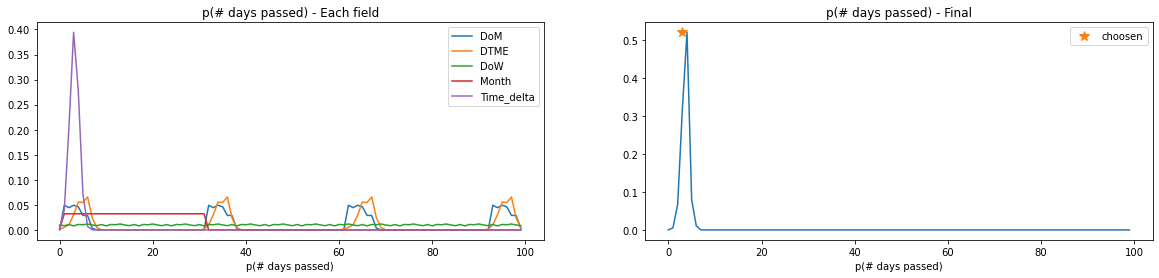





********** Generating element 20 of 20 **********
**Generating k_symbol
Selected nan


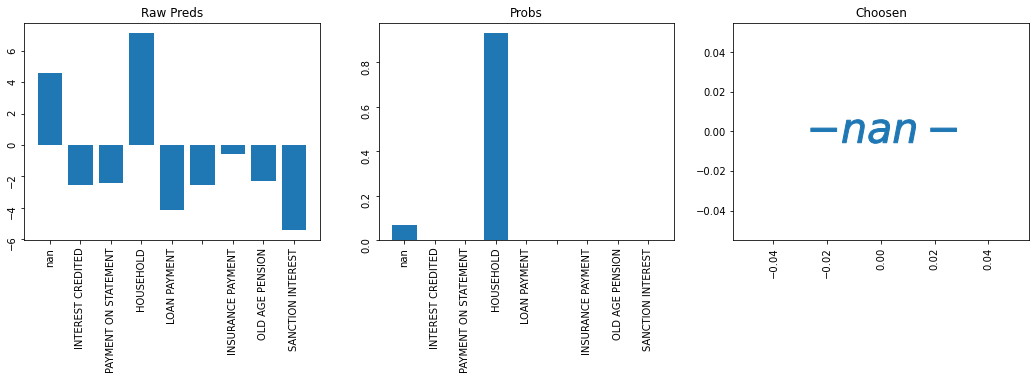

**Generating operation
Selected CREDIT IN CASH


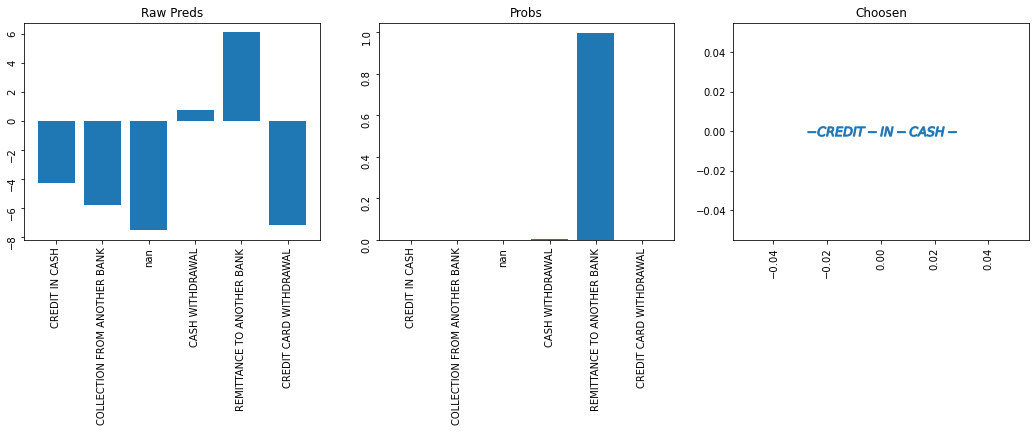

**Generating type
Selected CREDIT


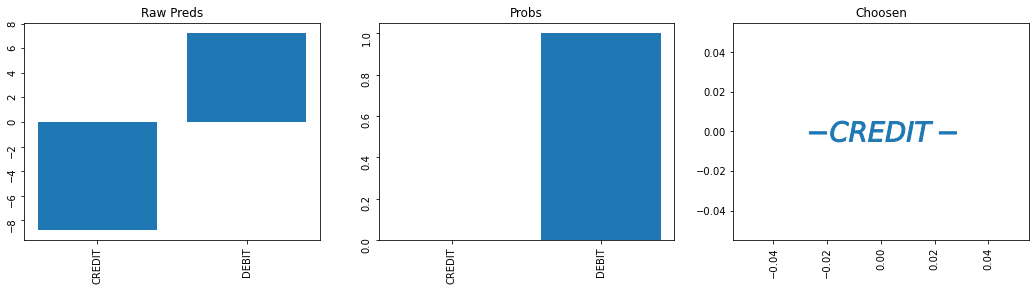

Amount. Unscaled mean = 3.41,	 logvar = 0.00	 sd = 1.00
Sampled value: 3.41
Unscaled value: 4234.88



*** Generating next date. Current Date is: 1993-03-03 0




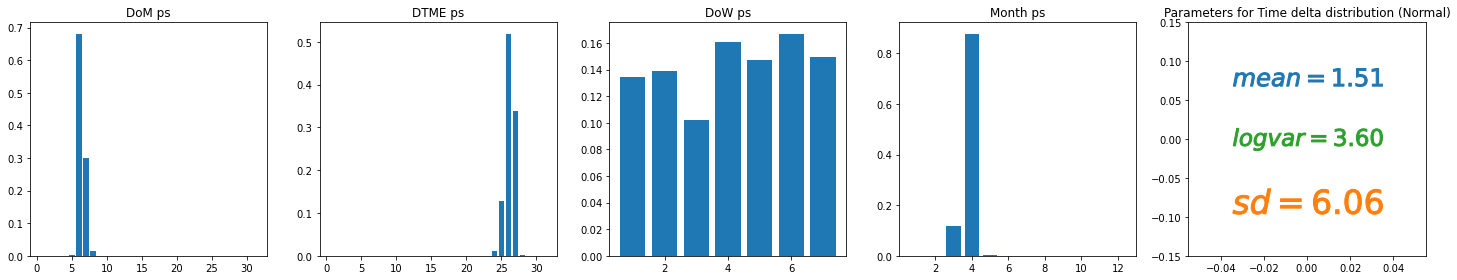

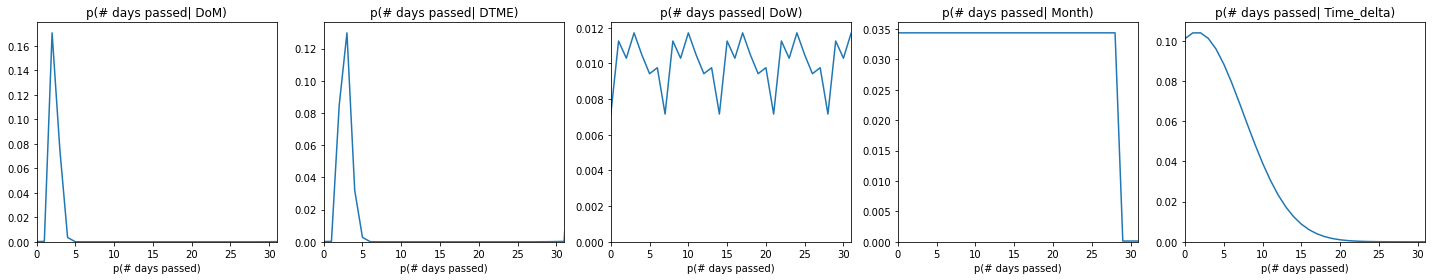

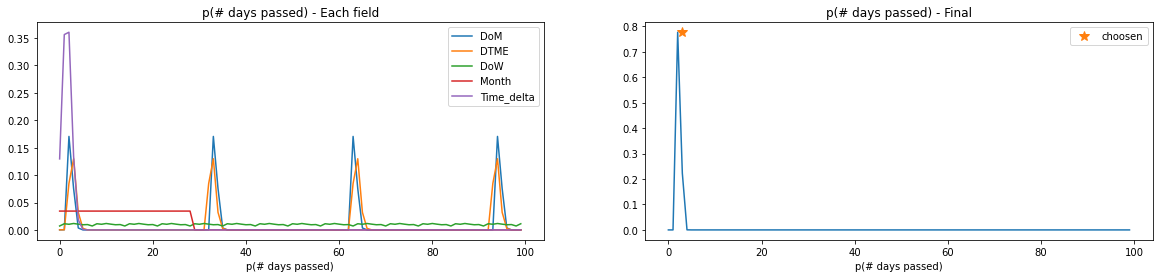

In [80]:
seqs_dfs, seqs, raw = generate_seqs(length= 20, 
                          ages=[75, 25], 
                          start_dates=[START_DATE, START_DATE+datetime.timedelta(days=31)], 
                          greedy_dates=False,
                          return_df_list=True)

### Note on distribution from time delta feature

In [81]:
from IPython.display import Latex

BF outputs 2 parameter, representing mean, logvar of a normal distribution, truncated at 0.

In [82]:
display(Latex("- BF outputs 2 parameter, representing mean, logvar of a normal distribution, truncated at 0."))
display(Latex("- Example: $mean = 2.1, logvar = 0.1$"))
display(Latex("- $sd = e^{logvar/2} = 1.05$"))
display(Latex(" "))
display(Latex("- Want: $p(timedelta = i| mean=2.1, sd=1.05) \propto Normal(i| mean=2.1, sd=1.05)$, for $i = 0, ..., maxdays$"))
display(Latex("- First, compute: $Normal(i| mean=2.1, sd=1.05)$, for $i = 0, ..., maxdays$"))
display(Latex("- Example (maxdays=10): 0.05 0.22 0.38 0.26 0.07 0.01 0.00 0.00 0.00 0.00"))

display(Latex("- Then normalize to ensure proper probability distribution"))

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

In [83]:
df = seqs_dfs[1]
df

amount  k_symbol_num  operation_num  type_num  days_passed  age  \
0    1750.709961             3              4         1            1   25   
1   16301.730469             0              1         0            4   25   
2    5214.279785             0              3         1            1   25   
3    1205.869995             5              4         1            2   25   
4     143.050003             1              2         0           19   25   
5      19.610001             2              3         1            0   25   
6    4095.459961             0              3         1            2   25   
7    3378.100098             3              4         1            3   25   
8   18591.480469             0              1         0            1   25   
9    2255.600098             5              4         1            3   25   
10   5913.589844             0              3         1            4   25   
11   4299.310059             0              3         1            9   25   
12    180.800003             1              2         0            9   25   
13     21.209999             2              3         1            0   25   
14   5974.490234             0              3         1            0   25   
15   4649.069824             3              4         1            5   25   
16  22349.740234             0              1         0            1   25   
17   3510.020020             5              4         1            4   25   
18   9544.059570             0              3         1            3   25   
19   5474.700195             0              3         1            7   25   

          date  
0   1993-02-02  
1   1993-02-06  
2   1993-02-07  
3   1993-02-09  
4   1993-02-28  
5   1993-02-28  
6   1993-03-02  
7   1993-03-05  
8   1993-03-06  
9   1993-03-09  
10  1993-03-13  
11  1993-03-22  
12  1993-03-31  
13  1993-03-31  
14  1993-03-31  
15  1993-04-05  
16  1993-04-06  
17  1993-04-10  
18  1993-04-13  
19  1993-04-20